In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from tsne import bh_sne
from MulticoreTSNE import MulticoreTSNE
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
from numpy.random import RandomState
np.random.seed(1)


from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [3]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [4]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [5]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [6]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [7]:
X.shape

(9339, 224, 224, 3)

In [8]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [9]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)       

In [10]:
filename = 'virussign-inceptionv3features.npy'
if os.path.exists(filename):
    print("Loading Inception-v3 extracted features from %s ..." %(filename))
    inceptionv3features = np.load(filename)
else:
    print("Extracting features from Inception-v3 layers ...")
    inceptionv3features = base_model.predict(X)
    print("Saving Inception-v3 extracted features into %s ..." %(filename))
    np.save(filename, inceptionv3features)

Loading Inception-v3 extracted features from virussign-inceptionv3features.npy ...


In [11]:
inceptionv3features.shape

(9339, 5, 5, 2048)

In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Training top_model and saving min training loss weights
num_epochs=500
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-top_model-weights-min_loss-inceptionv3-avgpool-Adam-500epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = inceptionv3features[train_indices]
    Y_train = Y[train_indices]
    X_test = inceptionv3features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
   
    top_input = Input(shape=inceptionv3features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)
    
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/500
8394/8394 [==============================] - 2s - loss: 3.2962 - acc: 0.0997 - val_loss: 2.7382 - val_acc: 0.2646
Epoch 2/500
8394/8394 [==============================] - 1s - loss: 2.7183 - acc: 0.2665 - val_loss: 2.4312 - val_acc: 0.3037
Epoch 3/500
8394/8394 [==============================] - 1s - loss: 2.4075 - acc: 0.3155 - val_loss: 2.2529 - val_acc: 0.3460
Epoch 4/500
8394/8394 [==============================] - 1s - loss: 2.2264 - acc: 0.3361 - val_loss: 2.1044 - val_acc: 0.3513
Epoch 5/500
8394/8394 [==============================] - 1s - loss: 2.0754 - acc: 0.3401 - val_loss: 1.9412 - val_acc: 0.3619
Epoch 6/500
8394/8394 [==============================] - 1s - loss: 1.9102 - acc: 0.3531 - val_loss: 1.7664 - val_acc: 0.5026
Epoch 7/500
8394/8394 [==============================] - 1s - loss: 1.7339 - acc: 0.4988 - val_loss: 1.6022 - val_acc: 0.6053
Epoch 8/500
8394/8394 [==============================] - 1s - loss: 1.5

8394/8394 [==============================] - 1s - loss: 0.1960 - acc: 0.9521 - val_loss: 0.2309 - val_acc: 0.9397
Epoch 66/500
8394/8394 [==============================] - 1s - loss: 0.1938 - acc: 0.9527 - val_loss: 0.2288 - val_acc: 0.9386
Epoch 67/500
8394/8394 [==============================] - 1s - loss: 0.1917 - acc: 0.9560 - val_loss: 0.2268 - val_acc: 0.9397
Epoch 68/500
8394/8394 [==============================] - 1s - loss: 0.1896 - acc: 0.9570 - val_loss: 0.2249 - val_acc: 0.9386
Epoch 69/500
8394/8394 [==============================] - 1s - loss: 0.1877 - acc: 0.9572 - val_loss: 0.2231 - val_acc: 0.9407
Epoch 70/500
8394/8394 [==============================] - 1s - loss: 0.1857 - acc: 0.9590 - val_loss: 0.2214 - val_acc: 0.9418
Epoch 71/500
8394/8394 [==============================] - 1s - loss: 0.1839 - acc: 0.9595 - val_loss: 0.2197 - val_acc: 0.9418
Epoch 72/500
8394/8394 [==============================] - 1s - loss: 0.1820 - acc: 0.9602 - val_loss: 0.2180 - val_acc: 0.94

8394/8394 [==============================] - 1s - loss: 0.1251 - acc: 0.9705 - val_loss: 0.1654 - val_acc: 0.9503
Epoch 130/500
8394/8394 [==============================] - 1s - loss: 0.1245 - acc: 0.9705 - val_loss: 0.1649 - val_acc: 0.9492
Epoch 131/500
8394/8394 [==============================] - 1s - loss: 0.1239 - acc: 0.9707 - val_loss: 0.1643 - val_acc: 0.9492
Epoch 132/500
8394/8394 [==============================] - 1s - loss: 0.1234 - acc: 0.9707 - val_loss: 0.1638 - val_acc: 0.9492
Epoch 133/500
8394/8394 [==============================] - 1s - loss: 0.1228 - acc: 0.9707 - val_loss: 0.1633 - val_acc: 0.9492
Epoch 134/500
8394/8394 [==============================] - 1s - loss: 0.1222 - acc: 0.9707 - val_loss: 0.1628 - val_acc: 0.9492
Epoch 135/500
8394/8394 [==============================] - 1s - loss: 0.1217 - acc: 0.9707 - val_loss: 0.1623 - val_acc: 0.9492
Epoch 136/500
8394/8394 [==============================] - 1s - loss: 0.1212 - acc: 0.9708 - val_loss: 0.1619 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0983 - acc: 0.9762 - val_loss: 0.1421 - val_acc: 0.9524
Epoch 194/500
8394/8394 [==============================] - 1s - loss: 0.0980 - acc: 0.9762 - val_loss: 0.1418 - val_acc: 0.9524
Epoch 195/500
8394/8394 [==============================] - 1s - loss: 0.0977 - acc: 0.9762 - val_loss: 0.1416 - val_acc: 0.9524
Epoch 196/500
8394/8394 [==============================] - 1s - loss: 0.0974 - acc: 0.9763 - val_loss: 0.1413 - val_acc: 0.9524
Epoch 197/500
8394/8394 [==============================] - 1s - loss: 0.0971 - acc: 0.9763 - val_loss: 0.1411 - val_acc: 0.9524
Epoch 198/500
8394/8394 [==============================] - 1s - loss: 0.0968 - acc: 0.9763 - val_loss: 0.1408 - val_acc: 0.9524
Epoch 199/500
8394/8394 [==============================] - 1s - loss: 0.0965 - acc: 0.9763 - val_loss: 0.1406 - val_acc: 0.9524
Epoch 200/500
8394/8394 [==============================] - 1s - loss: 0.0963 - acc: 0.9764 - val_loss: 0.1404 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0832 - acc: 0.9801 - val_loss: 0.1302 - val_acc: 0.9545
Epoch 258/500
8394/8394 [==============================] - 1s - loss: 0.0830 - acc: 0.9802 - val_loss: 0.1301 - val_acc: 0.9545
Epoch 259/500
8394/8394 [==============================] - 1s - loss: 0.0828 - acc: 0.9803 - val_loss: 0.1300 - val_acc: 0.9545
Epoch 260/500
8394/8394 [==============================] - 1s - loss: 0.0826 - acc: 0.9805 - val_loss: 0.1298 - val_acc: 0.9545
Epoch 261/500
8394/8394 [==============================] - 1s - loss: 0.0824 - acc: 0.9805 - val_loss: 0.1297 - val_acc: 0.9545
Epoch 262/500
8394/8394 [==============================] - 1s - loss: 0.0823 - acc: 0.9805 - val_loss: 0.1296 - val_acc: 0.9545
Epoch 263/500
8394/8394 [==============================] - 1s - loss: 0.0821 - acc: 0.9805 - val_loss: 0.1294 - val_acc: 0.9545
Epoch 264/500
8394/8394 [==============================] - 1s - loss: 0.0819 - acc: 0.9806 - val_loss: 0.1293 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0733 - acc: 0.9828 - val_loss: 0.1235 - val_acc: 0.9556
Epoch 322/500
8394/8394 [==============================] - 1s - loss: 0.0731 - acc: 0.9828 - val_loss: 0.1234 - val_acc: 0.9556
Epoch 323/500
8394/8394 [==============================] - 1s - loss: 0.0730 - acc: 0.9828 - val_loss: 0.1233 - val_acc: 0.9556
Epoch 324/500
8394/8394 [==============================] - 1s - loss: 0.0729 - acc: 0.9828 - val_loss: 0.1232 - val_acc: 0.9556
Epoch 325/500
8394/8394 [==============================] - 1s - loss: 0.0728 - acc: 0.9830 - val_loss: 0.1232 - val_acc: 0.9556
Epoch 326/500
8394/8394 [==============================] - 1s - loss: 0.0726 - acc: 0.9831 - val_loss: 0.1231 - val_acc: 0.9556
Epoch 327/500
8394/8394 [==============================] - 1s - loss: 0.0725 - acc: 0.9831 - val_loss: 0.1230 - val_acc: 0.9556
Epoch 328/500
8394/8394 [==============================] - 1s - loss: 0.0724 - acc: 0.9831 - val_loss: 0.1229 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0662 - acc: 0.9855 - val_loss: 0.1193 - val_acc: 0.9545
Epoch 386/500
8394/8394 [==============================] - 1s - loss: 0.0662 - acc: 0.9855 - val_loss: 0.1192 - val_acc: 0.9545
Epoch 387/500
8394/8394 [==============================] - 1s - loss: 0.0661 - acc: 0.9855 - val_loss: 0.1192 - val_acc: 0.9545
Epoch 388/500
8394/8394 [==============================] - 1s - loss: 0.0660 - acc: 0.9855 - val_loss: 0.1191 - val_acc: 0.9545
Epoch 389/500
8394/8394 [==============================] - 1s - loss: 0.0659 - acc: 0.9855 - val_loss: 0.1191 - val_acc: 0.9545
Epoch 390/500
8394/8394 [==============================] - 1s - loss: 0.0658 - acc: 0.9855 - val_loss: 0.1190 - val_acc: 0.9545
Epoch 391/500
8394/8394 [==============================] - 1s - loss: 0.0657 - acc: 0.9855 - val_loss: 0.1190 - val_acc: 0.9545
Epoch 392/500
8394/8394 [==============================] - 1s - loss: 0.0656 - acc: 0.9856 - val_loss: 0.1189 - val_ac

8394/8394 [==============================] - 1s - loss: 0.0610 - acc: 0.9864 - val_loss: 0.1166 - val_acc: 0.9545
Epoch 450/500
8394/8394 [==============================] - 1s - loss: 0.0609 - acc: 0.9864 - val_loss: 0.1166 - val_acc: 0.9545
Epoch 451/500
8394/8394 [==============================] - 1s - loss: 0.0609 - acc: 0.9864 - val_loss: 0.1165 - val_acc: 0.9545
Epoch 452/500
8394/8394 [==============================] - 1s - loss: 0.0608 - acc: 0.9864 - val_loss: 0.1165 - val_acc: 0.9545
Epoch 453/500
8394/8394 [==============================] - 1s - loss: 0.0607 - acc: 0.9864 - val_loss: 0.1165 - val_acc: 0.9545
Epoch 454/500
8394/8394 [==============================] - 1s - loss: 0.0607 - acc: 0.9864 - val_loss: 0.1164 - val_acc: 0.9545
Epoch 455/500
8394/8394 [==============================] - 1s - loss: 0.0606 - acc: 0.9864 - val_loss: 0.1164 - val_acc: 0.9545
Epoch 456/500
8394/8394 [==============================] - 1s - loss: 0.0605 - acc: 0.9864 - val_loss: 0.1164 - val_ac

8397/8397 [==============================] - 1s - loss: 1.3319 - acc: 0.7162 - val_loss: 1.2383 - val_acc: 0.7463
Epoch 13/500
8397/8397 [==============================] - 1s - loss: 1.2302 - acc: 0.7343 - val_loss: 1.1473 - val_acc: 0.7601
Epoch 14/500
8397/8397 [==============================] - 1s - loss: 1.1391 - acc: 0.7602 - val_loss: 1.0626 - val_acc: 0.7856
Epoch 15/500
8397/8397 [==============================] - 1s - loss: 1.0542 - acc: 0.7890 - val_loss: 0.9838 - val_acc: 0.8259
Epoch 16/500
8397/8397 [==============================] - 1s - loss: 0.9753 - acc: 0.8214 - val_loss: 0.9128 - val_acc: 0.8503
Epoch 17/500
8397/8397 [==============================] - 1s - loss: 0.9041 - acc: 0.8405 - val_loss: 0.8514 - val_acc: 0.8503
Epoch 18/500
8397/8397 [==============================] - 1s - loss: 0.8426 - acc: 0.8458 - val_loss: 0.7996 - val_acc: 0.8429
Epoch 19/500
8397/8397 [==============================] - 1s - loss: 0.7907 - acc: 0.8541 - val_loss: 0.7550 - val_acc: 0.84

8397/8397 [==============================] - 1s - loss: 0.2054 - acc: 0.9543 - val_loss: 0.2184 - val_acc: 0.9533
Epoch 77/500
8397/8397 [==============================] - 1s - loss: 0.2037 - acc: 0.9544 - val_loss: 0.2168 - val_acc: 0.9533
Epoch 78/500
8397/8397 [==============================] - 1s - loss: 0.2020 - acc: 0.9546 - val_loss: 0.2153 - val_acc: 0.9544
Epoch 79/500
8397/8397 [==============================] - 1s - loss: 0.2003 - acc: 0.9546 - val_loss: 0.2138 - val_acc: 0.9544
Epoch 80/500
8397/8397 [==============================] - 1s - loss: 0.1987 - acc: 0.9546 - val_loss: 0.2122 - val_acc: 0.9544
Epoch 81/500
8397/8397 [==============================] - 1s - loss: 0.1971 - acc: 0.9550 - val_loss: 0.2107 - val_acc: 0.9554
Epoch 82/500
8397/8397 [==============================] - 1s - loss: 0.1955 - acc: 0.9553 - val_loss: 0.2093 - val_acc: 0.9554
Epoch 83/500
8397/8397 [==============================] - 1s - loss: 0.1940 - acc: 0.9555 - val_loss: 0.2078 - val_acc: 0.95

8397/8397 [==============================] - 1s - loss: 0.1386 - acc: 0.9653 - val_loss: 0.1594 - val_acc: 0.9575
Epoch 141/500
8397/8397 [==============================] - 1s - loss: 0.1379 - acc: 0.9655 - val_loss: 0.1588 - val_acc: 0.9575
Epoch 142/500
8397/8397 [==============================] - 1s - loss: 0.1373 - acc: 0.9656 - val_loss: 0.1583 - val_acc: 0.9586
Epoch 143/500
8397/8397 [==============================] - 1s - loss: 0.1367 - acc: 0.9669 - val_loss: 0.1578 - val_acc: 0.9586
Epoch 144/500
8397/8397 [==============================] - 1s - loss: 0.1361 - acc: 0.9670 - val_loss: 0.1572 - val_acc: 0.9586
Epoch 145/500
8397/8397 [==============================] - 1s - loss: 0.1355 - acc: 0.9670 - val_loss: 0.1567 - val_acc: 0.9586
Epoch 146/500
8397/8397 [==============================] - 1s - loss: 0.1349 - acc: 0.9670 - val_loss: 0.1562 - val_acc: 0.9586
Epoch 147/500
8397/8397 [==============================] - 1s - loss: 0.1343 - acc: 0.9670 - val_loss: 0.1557 - val_ac

8397/8397 [==============================] - 1s - loss: 0.1086 - acc: 0.9725 - val_loss: 0.1348 - val_acc: 0.9639
Epoch 205/500
8397/8397 [==============================] - 1s - loss: 0.1082 - acc: 0.9725 - val_loss: 0.1345 - val_acc: 0.9639
Epoch 206/500
8397/8397 [==============================] - 1s - loss: 0.1079 - acc: 0.9725 - val_loss: 0.1343 - val_acc: 0.9671
Epoch 207/500
8397/8397 [==============================] - 1s - loss: 0.1076 - acc: 0.9728 - val_loss: 0.1340 - val_acc: 0.9671
Epoch 208/500
8397/8397 [==============================] - 1s - loss: 0.1072 - acc: 0.9728 - val_loss: 0.1338 - val_acc: 0.9671
Epoch 209/500
8397/8397 [==============================] - 1s - loss: 0.1069 - acc: 0.9730 - val_loss: 0.1335 - val_acc: 0.9671
Epoch 210/500
8397/8397 [==============================] - 1s - loss: 0.1066 - acc: 0.9732 - val_loss: 0.1332 - val_acc: 0.9671
Epoch 211/500
8397/8397 [==============================] - 1s - loss: 0.1062 - acc: 0.9732 - val_loss: 0.1330 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0912 - acc: 0.9778 - val_loss: 0.1215 - val_acc: 0.9692
Epoch 269/500
8397/8397 [==============================] - 1s - loss: 0.0909 - acc: 0.9778 - val_loss: 0.1214 - val_acc: 0.9692
Epoch 270/500
8397/8397 [==============================] - 1s - loss: 0.0907 - acc: 0.9780 - val_loss: 0.1212 - val_acc: 0.9692
Epoch 271/500
8397/8397 [==============================] - 1s - loss: 0.0905 - acc: 0.9781 - val_loss: 0.1210 - val_acc: 0.9692
Epoch 272/500
8397/8397 [==============================] - 1s - loss: 0.0903 - acc: 0.9782 - val_loss: 0.1209 - val_acc: 0.9692
Epoch 273/500
8397/8397 [==============================] - 1s - loss: 0.0901 - acc: 0.9783 - val_loss: 0.1207 - val_acc: 0.9692
Epoch 274/500
8397/8397 [==============================] - 1s - loss: 0.0899 - acc: 0.9783 - val_loss: 0.1206 - val_acc: 0.9692
Epoch 275/500
8397/8397 [==============================] - 1s - loss: 0.0897 - acc: 0.9787 - val_loss: 0.1204 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0796 - acc: 0.9815 - val_loss: 0.1133 - val_acc: 0.9692
Epoch 333/500
8397/8397 [==============================] - 1s - loss: 0.0795 - acc: 0.9815 - val_loss: 0.1132 - val_acc: 0.9692
Epoch 334/500
8397/8397 [==============================] - 1s - loss: 0.0793 - acc: 0.9815 - val_loss: 0.1131 - val_acc: 0.9692
Epoch 335/500
8397/8397 [==============================] - 1s - loss: 0.0792 - acc: 0.9815 - val_loss: 0.1130 - val_acc: 0.9692
Epoch 336/500
8397/8397 [==============================] - 1s - loss: 0.0790 - acc: 0.9817 - val_loss: 0.1129 - val_acc: 0.9692
Epoch 337/500
8397/8397 [==============================] - 1s - loss: 0.0789 - acc: 0.9817 - val_loss: 0.1128 - val_acc: 0.9692
Epoch 338/500
8397/8397 [==============================] - 1s - loss: 0.0787 - acc: 0.9817 - val_loss: 0.1127 - val_acc: 0.9692
Epoch 339/500
8397/8397 [==============================] - 1s - loss: 0.0786 - acc: 0.9817 - val_loss: 0.1126 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0714 - acc: 0.9839 - val_loss: 0.1078 - val_acc: 0.9703
Epoch 397/500
8397/8397 [==============================] - 1s - loss: 0.0713 - acc: 0.9839 - val_loss: 0.1077 - val_acc: 0.9703
Epoch 398/500
8397/8397 [==============================] - 1s - loss: 0.0711 - acc: 0.9839 - val_loss: 0.1077 - val_acc: 0.9703
Epoch 399/500
8397/8397 [==============================] - 1s - loss: 0.0710 - acc: 0.9839 - val_loss: 0.1076 - val_acc: 0.9703
Epoch 400/500
8397/8397 [==============================] - 1s - loss: 0.0709 - acc: 0.9839 - val_loss: 0.1075 - val_acc: 0.9703
Epoch 401/500
8397/8397 [==============================] - 1s - loss: 0.0708 - acc: 0.9839 - val_loss: 0.1075 - val_acc: 0.9703
Epoch 402/500
8397/8397 [==============================] - 1s - loss: 0.0707 - acc: 0.9839 - val_loss: 0.1074 - val_acc: 0.9703
Epoch 403/500
8397/8397 [==============================] - 1s - loss: 0.0706 - acc: 0.9839 - val_loss: 0.1073 - val_ac

8397/8397 [==============================] - 1s - loss: 0.0652 - acc: 0.9856 - val_loss: 0.1040 - val_acc: 0.9724
Epoch 461/500
8397/8397 [==============================] - 1s - loss: 0.0651 - acc: 0.9856 - val_loss: 0.1039 - val_acc: 0.9724
Epoch 462/500
8397/8397 [==============================] - 1s - loss: 0.0650 - acc: 0.9856 - val_loss: 0.1039 - val_acc: 0.9724
Epoch 463/500
8397/8397 [==============================] - 1s - loss: 0.0650 - acc: 0.9856 - val_loss: 0.1038 - val_acc: 0.9724
Epoch 464/500
8397/8397 [==============================] - 1s - loss: 0.0649 - acc: 0.9856 - val_loss: 0.1038 - val_acc: 0.9724
Epoch 465/500
8397/8397 [==============================] - 1s - loss: 0.0648 - acc: 0.9856 - val_loss: 0.1037 - val_acc: 0.9724
Epoch 466/500
8397/8397 [==============================] - 1s - loss: 0.0647 - acc: 0.9856 - val_loss: 0.1037 - val_acc: 0.9724
Epoch 467/500
8397/8397 [==============================] - 1s - loss: 0.0646 - acc: 0.9856 - val_loss: 0.1036 - val_ac

8401/8401 [==============================] - 1s - loss: 0.5152 - acc: 0.8908 - val_loss: 0.5000 - val_acc: 0.8923
Epoch 24/500
8401/8401 [==============================] - 1s - loss: 0.4927 - acc: 0.8968 - val_loss: 0.4788 - val_acc: 0.8966
Epoch 25/500
8401/8401 [==============================] - 1s - loss: 0.4715 - acc: 0.9006 - val_loss: 0.4585 - val_acc: 0.8977
Epoch 26/500
8401/8401 [==============================] - 1s - loss: 0.4511 - acc: 0.9041 - val_loss: 0.4399 - val_acc: 0.9009
Epoch 27/500
8401/8401 [==============================] - 1s - loss: 0.4324 - acc: 0.9073 - val_loss: 0.4229 - val_acc: 0.9094
Epoch 28/500
8401/8401 [==============================] - 1s - loss: 0.4154 - acc: 0.9132 - val_loss: 0.4078 - val_acc: 0.9136
Epoch 29/500
8401/8401 [==============================] - 1s - loss: 0.4001 - acc: 0.9185 - val_loss: 0.3942 - val_acc: 0.9179
Epoch 30/500
8401/8401 [==============================] - 1s - loss: 0.3863 - acc: 0.9216 - val_loss: 0.3819 - val_acc: 0.92

8401/8401 [==============================] - 1s - loss: 0.1578 - acc: 0.9651 - val_loss: 0.1877 - val_acc: 0.9488
Epoch 88/500
8401/8401 [==============================] - 1s - loss: 0.1565 - acc: 0.9651 - val_loss: 0.1868 - val_acc: 0.9488
Epoch 89/500
8401/8401 [==============================] - 1s - loss: 0.1553 - acc: 0.9652 - val_loss: 0.1858 - val_acc: 0.9499
Epoch 90/500
8401/8401 [==============================] - 1s - loss: 0.1541 - acc: 0.9668 - val_loss: 0.1849 - val_acc: 0.9499
Epoch 91/500
8401/8401 [==============================] - 1s - loss: 0.1529 - acc: 0.9673 - val_loss: 0.1840 - val_acc: 0.9499
Epoch 92/500
8401/8401 [==============================] - 1s - loss: 0.1518 - acc: 0.9673 - val_loss: 0.1831 - val_acc: 0.9499
Epoch 93/500
8401/8401 [==============================] - 1s - loss: 0.1507 - acc: 0.9674 - val_loss: 0.1823 - val_acc: 0.9499
Epoch 94/500
8401/8401 [==============================] - 1s - loss: 0.1496 - acc: 0.9675 - val_loss: 0.1814 - val_acc: 0.94

8401/8401 [==============================] - 1s - loss: 0.1089 - acc: 0.9751 - val_loss: 0.1517 - val_acc: 0.9584
Epoch 152/500
8401/8401 [==============================] - 1s - loss: 0.1084 - acc: 0.9751 - val_loss: 0.1513 - val_acc: 0.9584
Epoch 153/500
8401/8401 [==============================] - 1s - loss: 0.1079 - acc: 0.9760 - val_loss: 0.1510 - val_acc: 0.9584
Epoch 154/500
8401/8401 [==============================] - 1s - loss: 0.1074 - acc: 0.9760 - val_loss: 0.1507 - val_acc: 0.9584
Epoch 155/500
8401/8401 [==============================] - 1s - loss: 0.1070 - acc: 0.9760 - val_loss: 0.1504 - val_acc: 0.9584
Epoch 156/500
8401/8401 [==============================] - 1s - loss: 0.1065 - acc: 0.9762 - val_loss: 0.1501 - val_acc: 0.9574
Epoch 157/500
8401/8401 [==============================] - 1s - loss: 0.1061 - acc: 0.9762 - val_loss: 0.1498 - val_acc: 0.9574
Epoch 158/500
8401/8401 [==============================] - 1s - loss: 0.1056 - acc: 0.9763 - val_loss: 0.1495 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0863 - acc: 0.9808 - val_loss: 0.1376 - val_acc: 0.9574
Epoch 216/500
8401/8401 [==============================] - 1s - loss: 0.0861 - acc: 0.9808 - val_loss: 0.1374 - val_acc: 0.9574
Epoch 217/500
8401/8401 [==============================] - 1s - loss: 0.0858 - acc: 0.9808 - val_loss: 0.1373 - val_acc: 0.9574
Epoch 218/500
8401/8401 [==============================] - 1s - loss: 0.0855 - acc: 0.9808 - val_loss: 0.1372 - val_acc: 0.9574
Epoch 219/500
8401/8401 [==============================] - 1s - loss: 0.0853 - acc: 0.9810 - val_loss: 0.1370 - val_acc: 0.9574
Epoch 220/500
8401/8401 [==============================] - 1s - loss: 0.0850 - acc: 0.9810 - val_loss: 0.1369 - val_acc: 0.9574
Epoch 221/500
8401/8401 [==============================] - 1s - loss: 0.0848 - acc: 0.9810 - val_loss: 0.1368 - val_acc: 0.9574
Epoch 222/500
8401/8401 [==============================] - 1s - loss: 0.0845 - acc: 0.9810 - val_loss: 0.1366 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0731 - acc: 0.9845 - val_loss: 0.1311 - val_acc: 0.9584
Epoch 280/500
8401/8401 [==============================] - 1s - loss: 0.0730 - acc: 0.9845 - val_loss: 0.1310 - val_acc: 0.9584
Epoch 281/500
8401/8401 [==============================] - 1s - loss: 0.0728 - acc: 0.9846 - val_loss: 0.1309 - val_acc: 0.9584
Epoch 282/500
8401/8401 [==============================] - 1s - loss: 0.0727 - acc: 0.9848 - val_loss: 0.1309 - val_acc: 0.9584
Epoch 283/500
8401/8401 [==============================] - 1s - loss: 0.0725 - acc: 0.9848 - val_loss: 0.1308 - val_acc: 0.9584
Epoch 284/500
8401/8401 [==============================] - 1s - loss: 0.0723 - acc: 0.9848 - val_loss: 0.1307 - val_acc: 0.9584
Epoch 285/500
8401/8401 [==============================] - 1s - loss: 0.0722 - acc: 0.9849 - val_loss: 0.1307 - val_acc: 0.9584
Epoch 286/500
8401/8401 [==============================] - 1s - loss: 0.0720 - acc: 0.9849 - val_loss: 0.1306 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0646 - acc: 0.9861 - val_loss: 0.1280 - val_acc: 0.9627
Epoch 344/500
8401/8401 [==============================] - 1s - loss: 0.0644 - acc: 0.9861 - val_loss: 0.1279 - val_acc: 0.9627
Epoch 345/500
8401/8401 [==============================] - 1s - loss: 0.0643 - acc: 0.9861 - val_loss: 0.1279 - val_acc: 0.9627
Epoch 346/500
8401/8401 [==============================] - 1s - loss: 0.0642 - acc: 0.9863 - val_loss: 0.1279 - val_acc: 0.9627
Epoch 347/500
8401/8401 [==============================] - 1s - loss: 0.0641 - acc: 0.9863 - val_loss: 0.1279 - val_acc: 0.9627
Epoch 348/500
8401/8401 [==============================] - 1s - loss: 0.0640 - acc: 0.9863 - val_loss: 0.1278 - val_acc: 0.9627
Epoch 349/500
8401/8401 [==============================] - 1s - loss: 0.0639 - acc: 0.9863 - val_loss: 0.1278 - val_acc: 0.9627
Epoch 350/500
8401/8401 [==============================] - 1s - loss: 0.0638 - acc: 0.9863 - val_loss: 0.1278 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0586 - acc: 0.9874 - val_loss: 0.1266 - val_acc: 0.9627
Epoch 408/500
8401/8401 [==============================] - 1s - loss: 0.0585 - acc: 0.9874 - val_loss: 0.1266 - val_acc: 0.9627
Epoch 409/500
8401/8401 [==============================] - 1s - loss: 0.0584 - acc: 0.9874 - val_loss: 0.1266 - val_acc: 0.9627
Epoch 410/500
8401/8401 [==============================] - 1s - loss: 0.0583 - acc: 0.9874 - val_loss: 0.1266 - val_acc: 0.9627
Epoch 411/500
8401/8401 [==============================] - 1s - loss: 0.0583 - acc: 0.9874 - val_loss: 0.1266 - val_acc: 0.9627
Epoch 412/500
8401/8401 [==============================] - 1s - loss: 0.0582 - acc: 0.9874 - val_loss: 0.1265 - val_acc: 0.9627
Epoch 413/500
8401/8401 [==============================] - 1s - loss: 0.0581 - acc: 0.9874 - val_loss: 0.1265 - val_acc: 0.9627
Epoch 414/500
8401/8401 [==============================] - 1s - loss: 0.0580 - acc: 0.9874 - val_loss: 0.1265 - val_ac

8401/8401 [==============================] - 1s - loss: 0.0542 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 472/500
8401/8401 [==============================] - 1s - loss: 0.0542 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 473/500
8401/8401 [==============================] - 1s - loss: 0.0541 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 474/500
8401/8401 [==============================] - 1s - loss: 0.0541 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 475/500
8401/8401 [==============================] - 1s - loss: 0.0540 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 476/500
8401/8401 [==============================] - 1s - loss: 0.0539 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 477/500
8401/8401 [==============================] - 1s - loss: 0.0539 - acc: 0.9879 - val_loss: 0.1261 - val_acc: 0.9627
Epoch 478/500
8401/8401 [==============================] - 1s - loss: 0.0538 - acc: 0.9879 - val_loss: 0.1261 - val_ac

8403/8403 [==============================] - 1s - loss: 0.3206 - acc: 0.9372 - val_loss: 0.3133 - val_acc: 0.9327
Epoch 35/500
8403/8403 [==============================] - 1s - loss: 0.3114 - acc: 0.9385 - val_loss: 0.3048 - val_acc: 0.9348
Epoch 36/500
8403/8403 [==============================] - 1s - loss: 0.3028 - acc: 0.9405 - val_loss: 0.2969 - val_acc: 0.9370
Epoch 37/500
8403/8403 [==============================] - 1s - loss: 0.2949 - acc: 0.9409 - val_loss: 0.2895 - val_acc: 0.9391
Epoch 38/500
8403/8403 [==============================] - 1s - loss: 0.2874 - acc: 0.9425 - val_loss: 0.2824 - val_acc: 0.9402
Epoch 39/500
8403/8403 [==============================] - 1s - loss: 0.2804 - acc: 0.9437 - val_loss: 0.2759 - val_acc: 0.9391
Epoch 40/500
8403/8403 [==============================] - 1s - loss: 0.2739 - acc: 0.9441 - val_loss: 0.2698 - val_acc: 0.9391
Epoch 41/500
8403/8403 [==============================] - 1s - loss: 0.2678 - acc: 0.9444 - val_loss: 0.2641 - val_acc: 0.94

8403/8403 [==============================] - 1s - loss: 0.1430 - acc: 0.9667 - val_loss: 0.1502 - val_acc: 0.9573
Epoch 99/500
8403/8403 [==============================] - 1s - loss: 0.1421 - acc: 0.9673 - val_loss: 0.1494 - val_acc: 0.9573
Epoch 100/500
8403/8403 [==============================] - 1s - loss: 0.1411 - acc: 0.9676 - val_loss: 0.1487 - val_acc: 0.9573
Epoch 101/500
8403/8403 [==============================] - 1s - loss: 0.1402 - acc: 0.9677 - val_loss: 0.1480 - val_acc: 0.9573
Epoch 102/500
8403/8403 [==============================] - 1s - loss: 0.1394 - acc: 0.9677 - val_loss: 0.1472 - val_acc: 0.9573
Epoch 103/500
8403/8403 [==============================] - 1s - loss: 0.1385 - acc: 0.9679 - val_loss: 0.1465 - val_acc: 0.9573
Epoch 104/500
8403/8403 [==============================] - 1s - loss: 0.1376 - acc: 0.9677 - val_loss: 0.1459 - val_acc: 0.9573
Epoch 105/500
8403/8403 [==============================] - 1s - loss: 0.1368 - acc: 0.9677 - val_loss: 0.1452 - val_acc

8403/8403 [==============================] - 1s - loss: 0.1037 - acc: 0.9755 - val_loss: 0.1210 - val_acc: 0.9626
Epoch 163/500
8403/8403 [==============================] - 1s - loss: 0.1033 - acc: 0.9756 - val_loss: 0.1207 - val_acc: 0.9626
Epoch 164/500
8403/8403 [==============================] - 1s - loss: 0.1029 - acc: 0.9761 - val_loss: 0.1204 - val_acc: 0.9626
Epoch 165/500
8403/8403 [==============================] - 1s - loss: 0.1025 - acc: 0.9761 - val_loss: 0.1202 - val_acc: 0.9626
Epoch 166/500
8403/8403 [==============================] - 1s - loss: 0.1021 - acc: 0.9763 - val_loss: 0.1199 - val_acc: 0.9626
Epoch 167/500
8403/8403 [==============================] - 1s - loss: 0.1017 - acc: 0.9769 - val_loss: 0.1197 - val_acc: 0.9637
Epoch 168/500
8403/8403 [==============================] - 1s - loss: 0.1014 - acc: 0.9769 - val_loss: 0.1194 - val_acc: 0.9637
Epoch 169/500
8403/8403 [==============================] - 1s - loss: 0.1010 - acc: 0.9769 - val_loss: 0.1192 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0841 - acc: 0.9820 - val_loss: 0.1089 - val_acc: 0.9637
Epoch 227/500
8403/8403 [==============================] - 1s - loss: 0.0839 - acc: 0.9820 - val_loss: 0.1088 - val_acc: 0.9637
Epoch 228/500
8403/8403 [==============================] - 1s - loss: 0.0836 - acc: 0.9820 - val_loss: 0.1087 - val_acc: 0.9637
Epoch 229/500
8403/8403 [==============================] - 1s - loss: 0.0834 - acc: 0.9823 - val_loss: 0.1085 - val_acc: 0.9637
Epoch 230/500
8403/8403 [==============================] - 1s - loss: 0.0832 - acc: 0.9823 - val_loss: 0.1084 - val_acc: 0.9637
Epoch 231/500
8403/8403 [==============================] - 1s - loss: 0.0829 - acc: 0.9824 - val_loss: 0.1083 - val_acc: 0.9637
Epoch 232/500
8403/8403 [==============================] - 1s - loss: 0.0827 - acc: 0.9824 - val_loss: 0.1082 - val_acc: 0.9637
Epoch 233/500
8403/8403 [==============================] - 1s - loss: 0.0825 - acc: 0.9824 - val_loss: 0.1080 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0721 - acc: 0.9841 - val_loss: 0.1029 - val_acc: 0.9647
Epoch 291/500
8403/8403 [==============================] - 1s - loss: 0.0720 - acc: 0.9841 - val_loss: 0.1028 - val_acc: 0.9647
Epoch 292/500
8403/8403 [==============================] - 1s - loss: 0.0718 - acc: 0.9841 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 293/500
8403/8403 [==============================] - 1s - loss: 0.0717 - acc: 0.9841 - val_loss: 0.1027 - val_acc: 0.9647
Epoch 294/500
8403/8403 [==============================] - 1s - loss: 0.0715 - acc: 0.9841 - val_loss: 0.1026 - val_acc: 0.9647
Epoch 295/500
8403/8403 [==============================] - 1s - loss: 0.0714 - acc: 0.9842 - val_loss: 0.1025 - val_acc: 0.9647
Epoch 296/500
8403/8403 [==============================] - 1s - loss: 0.0712 - acc: 0.9842 - val_loss: 0.1025 - val_acc: 0.9647
Epoch 297/500
8403/8403 [==============================] - 1s - loss: 0.0711 - acc: 0.9842 - val_loss: 0.1024 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0641 - acc: 0.9861 - val_loss: 0.0996 - val_acc: 0.9658
Epoch 355/500
8403/8403 [==============================] - 1s - loss: 0.0640 - acc: 0.9861 - val_loss: 0.0996 - val_acc: 0.9658
Epoch 356/500
8403/8403 [==============================] - 1s - loss: 0.0639 - acc: 0.9861 - val_loss: 0.0995 - val_acc: 0.9658
Epoch 357/500
8403/8403 [==============================] - 1s - loss: 0.0638 - acc: 0.9861 - val_loss: 0.0995 - val_acc: 0.9658
Epoch 358/500
8403/8403 [==============================] - 1s - loss: 0.0637 - acc: 0.9861 - val_loss: 0.0994 - val_acc: 0.9658
Epoch 359/500
8403/8403 [==============================] - 1s - loss: 0.0636 - acc: 0.9861 - val_loss: 0.0994 - val_acc: 0.9658
Epoch 360/500
8403/8403 [==============================] - 1s - loss: 0.0635 - acc: 0.9861 - val_loss: 0.0994 - val_acc: 0.9658
Epoch 361/500
8403/8403 [==============================] - 1s - loss: 0.0634 - acc: 0.9861 - val_loss: 0.0993 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0584 - acc: 0.9876 - val_loss: 0.0978 - val_acc: 0.9669
Epoch 419/500
8403/8403 [==============================] - 1s - loss: 0.0583 - acc: 0.9876 - val_loss: 0.0978 - val_acc: 0.9669
Epoch 420/500
8403/8403 [==============================] - 1s - loss: 0.0583 - acc: 0.9876 - val_loss: 0.0978 - val_acc: 0.9669
Epoch 421/500
8403/8403 [==============================] - 1s - loss: 0.0582 - acc: 0.9877 - val_loss: 0.0978 - val_acc: 0.9669
Epoch 422/500
8403/8403 [==============================] - 1s - loss: 0.0581 - acc: 0.9877 - val_loss: 0.0977 - val_acc: 0.9669
Epoch 423/500
8403/8403 [==============================] - 1s - loss: 0.0580 - acc: 0.9877 - val_loss: 0.0977 - val_acc: 0.9669
Epoch 424/500
8403/8403 [==============================] - 1s - loss: 0.0580 - acc: 0.9877 - val_loss: 0.0977 - val_acc: 0.9669
Epoch 425/500
8403/8403 [==============================] - 1s - loss: 0.0579 - acc: 0.9877 - val_loss: 0.0977 - val_ac

8403/8403 [==============================] - 1s - loss: 0.0542 - acc: 0.9880 - val_loss: 0.0969 - val_acc: 0.9669
Epoch 483/500
8403/8403 [==============================] - 1s - loss: 0.0542 - acc: 0.9881 - val_loss: 0.0969 - val_acc: 0.9669
Epoch 484/500
8403/8403 [==============================] - 1s - loss: 0.0541 - acc: 0.9881 - val_loss: 0.0969 - val_acc: 0.9669
Epoch 485/500
8403/8403 [==============================] - 1s - loss: 0.0540 - acc: 0.9881 - val_loss: 0.0968 - val_acc: 0.9669
Epoch 486/500
8403/8403 [==============================] - 1s - loss: 0.0540 - acc: 0.9881 - val_loss: 0.0968 - val_acc: 0.9669
Epoch 487/500
8403/8403 [==============================] - 1s - loss: 0.0539 - acc: 0.9881 - val_loss: 0.0968 - val_acc: 0.9669
Epoch 488/500
8403/8403 [==============================] - 1s - loss: 0.0539 - acc: 0.9881 - val_loss: 0.0968 - val_acc: 0.9669
Epoch 489/500
8403/8403 [==============================] - 1s - loss: 0.0538 - acc: 0.9881 - val_loss: 0.0968 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2789 - acc: 0.9376 - val_loss: 0.2832 - val_acc: 0.9283
Epoch 46/500
8404/8404 [==============================] - 1s - loss: 0.2733 - acc: 0.9390 - val_loss: 0.2781 - val_acc: 0.9294
Epoch 47/500
8404/8404 [==============================] - 1s - loss: 0.2680 - acc: 0.9406 - val_loss: 0.2734 - val_acc: 0.9316
Epoch 48/500
8404/8404 [==============================] - 1s - loss: 0.2629 - acc: 0.9416 - val_loss: 0.2689 - val_acc: 0.9316
Epoch 49/500
8404/8404 [==============================] - 1s - loss: 0.2581 - acc: 0.9423 - val_loss: 0.2648 - val_acc: 0.9337
Epoch 50/500
8404/8404 [==============================] - 1s - loss: 0.2537 - acc: 0.9424 - val_loss: 0.2609 - val_acc: 0.9326
Epoch 51/500
8404/8404 [==============================] - 1s - loss: 0.2495 - acc: 0.9434 - val_loss: 0.2572 - val_acc: 0.9348
Epoch 52/500
8404/8404 [==============================] - 1s - loss: 0.2455 - acc: 0.9438 - val_loss: 0.2536 - val_acc: 0.93

8404/8404 [==============================] - 1s - loss: 0.1436 - acc: 0.9685 - val_loss: 0.1602 - val_acc: 0.9529
Epoch 110/500
8404/8404 [==============================] - 1s - loss: 0.1428 - acc: 0.9686 - val_loss: 0.1594 - val_acc: 0.9540
Epoch 111/500
8404/8404 [==============================] - 1s - loss: 0.1419 - acc: 0.9687 - val_loss: 0.1587 - val_acc: 0.9540
Epoch 112/500
8404/8404 [==============================] - 1s - loss: 0.1411 - acc: 0.9688 - val_loss: 0.1579 - val_acc: 0.9540
Epoch 113/500
8404/8404 [==============================] - 1s - loss: 0.1403 - acc: 0.9689 - val_loss: 0.1572 - val_acc: 0.9540
Epoch 114/500
8404/8404 [==============================] - 1s - loss: 0.1394 - acc: 0.9689 - val_loss: 0.1565 - val_acc: 0.9551
Epoch 115/500
8404/8404 [==============================] - 1s - loss: 0.1386 - acc: 0.9689 - val_loss: 0.1558 - val_acc: 0.9551
Epoch 116/500
8404/8404 [==============================] - 1s - loss: 0.1379 - acc: 0.9689 - val_loss: 0.1551 - val_ac

8404/8404 [==============================] - 1s - loss: 0.1064 - acc: 0.9762 - val_loss: 0.1285 - val_acc: 0.9615
Epoch 174/500
8404/8404 [==============================] - 1s - loss: 0.1060 - acc: 0.9762 - val_loss: 0.1282 - val_acc: 0.9615
Epoch 175/500
8404/8404 [==============================] - 1s - loss: 0.1056 - acc: 0.9763 - val_loss: 0.1279 - val_acc: 0.9615
Epoch 176/500
8404/8404 [==============================] - 1s - loss: 0.1052 - acc: 0.9764 - val_loss: 0.1276 - val_acc: 0.9615
Epoch 177/500
8404/8404 [==============================] - 1s - loss: 0.1049 - acc: 0.9764 - val_loss: 0.1273 - val_acc: 0.9615
Epoch 178/500
8404/8404 [==============================] - 1s - loss: 0.1045 - acc: 0.9764 - val_loss: 0.1270 - val_acc: 0.9615
Epoch 179/500
8404/8404 [==============================] - 1s - loss: 0.1041 - acc: 0.9764 - val_loss: 0.1268 - val_acc: 0.9615
Epoch 180/500
8404/8404 [==============================] - 1s - loss: 0.1037 - acc: 0.9769 - val_loss: 0.1265 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0871 - acc: 0.9798 - val_loss: 0.1146 - val_acc: 0.9636
Epoch 238/500
8404/8404 [==============================] - 1s - loss: 0.0869 - acc: 0.9799 - val_loss: 0.1144 - val_acc: 0.9647
Epoch 239/500
8404/8404 [==============================] - 1s - loss: 0.0867 - acc: 0.9799 - val_loss: 0.1143 - val_acc: 0.9647
Epoch 240/500
8404/8404 [==============================] - 1s - loss: 0.0864 - acc: 0.9799 - val_loss: 0.1141 - val_acc: 0.9647
Epoch 241/500
8404/8404 [==============================] - 1s - loss: 0.0862 - acc: 0.9799 - val_loss: 0.1140 - val_acc: 0.9647
Epoch 242/500
8404/8404 [==============================] - 1s - loss: 0.0860 - acc: 0.9799 - val_loss: 0.1139 - val_acc: 0.9647
Epoch 243/500
8404/8404 [==============================] - 1s - loss: 0.0858 - acc: 0.9799 - val_loss: 0.1137 - val_acc: 0.9647
Epoch 244/500
8404/8404 [==============================] - 1s - loss: 0.0856 - acc: 0.9801 - val_loss: 0.1136 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0751 - acc: 0.9832 - val_loss: 0.1074 - val_acc: 0.9658
Epoch 302/500
8404/8404 [==============================] - 1s - loss: 0.0750 - acc: 0.9833 - val_loss: 0.1073 - val_acc: 0.9668
Epoch 303/500
8404/8404 [==============================] - 1s - loss: 0.0748 - acc: 0.9833 - val_loss: 0.1072 - val_acc: 0.9668
Epoch 304/500
8404/8404 [==============================] - 1s - loss: 0.0747 - acc: 0.9835 - val_loss: 0.1071 - val_acc: 0.9668
Epoch 305/500
8404/8404 [==============================] - 1s - loss: 0.0745 - acc: 0.9835 - val_loss: 0.1070 - val_acc: 0.9668
Epoch 306/500
8404/8404 [==============================] - 1s - loss: 0.0744 - acc: 0.9835 - val_loss: 0.1070 - val_acc: 0.9668
Epoch 307/500
8404/8404 [==============================] - 1s - loss: 0.0742 - acc: 0.9836 - val_loss: 0.1069 - val_acc: 0.9668
Epoch 308/500
8404/8404 [==============================] - 1s - loss: 0.0741 - acc: 0.9836 - val_loss: 0.1068 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0669 - acc: 0.9854 - val_loss: 0.1033 - val_acc: 0.9668
Epoch 366/500
8404/8404 [==============================] - 1s - loss: 0.0668 - acc: 0.9854 - val_loss: 0.1033 - val_acc: 0.9668
Epoch 367/500
8404/8404 [==============================] - 1s - loss: 0.0667 - acc: 0.9854 - val_loss: 0.1033 - val_acc: 0.9668
Epoch 368/500
8404/8404 [==============================] - 1s - loss: 0.0666 - acc: 0.9854 - val_loss: 0.1032 - val_acc: 0.9668
Epoch 369/500
8404/8404 [==============================] - 1s - loss: 0.0665 - acc: 0.9855 - val_loss: 0.1032 - val_acc: 0.9668
Epoch 370/500
8404/8404 [==============================] - 1s - loss: 0.0664 - acc: 0.9855 - val_loss: 0.1031 - val_acc: 0.9668
Epoch 371/500
8404/8404 [==============================] - 1s - loss: 0.0663 - acc: 0.9855 - val_loss: 0.1031 - val_acc: 0.9668
Epoch 372/500
8404/8404 [==============================] - 1s - loss: 0.0662 - acc: 0.9855 - val_loss: 0.1030 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0610 - acc: 0.9863 - val_loss: 0.1010 - val_acc: 0.9668
Epoch 430/500
8404/8404 [==============================] - 1s - loss: 0.0609 - acc: 0.9863 - val_loss: 0.1010 - val_acc: 0.9668
Epoch 431/500
8404/8404 [==============================] - 1s - loss: 0.0608 - acc: 0.9863 - val_loss: 0.1010 - val_acc: 0.9668
Epoch 432/500
8404/8404 [==============================] - 1s - loss: 0.0608 - acc: 0.9863 - val_loss: 0.1009 - val_acc: 0.9668
Epoch 433/500
8404/8404 [==============================] - 1s - loss: 0.0607 - acc: 0.9863 - val_loss: 0.1009 - val_acc: 0.9668
Epoch 434/500
8404/8404 [==============================] - 1s - loss: 0.0606 - acc: 0.9863 - val_loss: 0.1009 - val_acc: 0.9668
Epoch 435/500
8404/8404 [==============================] - 1s - loss: 0.0605 - acc: 0.9863 - val_loss: 0.1009 - val_acc: 0.9668
Epoch 436/500
8404/8404 [==============================] - 1s - loss: 0.0604 - acc: 0.9863 - val_loss: 0.1008 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0565 - acc: 0.9873 - val_loss: 0.0997 - val_acc: 0.9668
Epoch 494/500
8404/8404 [==============================] - 1s - loss: 0.0564 - acc: 0.9873 - val_loss: 0.0997 - val_acc: 0.9668
Epoch 495/500
8404/8404 [==============================] - 1s - loss: 0.0564 - acc: 0.9873 - val_loss: 0.0997 - val_acc: 0.9668
Epoch 496/500
8404/8404 [==============================] - 1s - loss: 0.0563 - acc: 0.9873 - val_loss: 0.0996 - val_acc: 0.9668
Epoch 497/500
8404/8404 [==============================] - 1s - loss: 0.0563 - acc: 0.9873 - val_loss: 0.0996 - val_acc: 0.9668
Epoch 498/500
8404/8404 [==============================] - 1s - loss: 0.0562 - acc: 0.9873 - val_loss: 0.0996 - val_acc: 0.9668
Epoch 499/500
8404/8404 [==============================] - 1s - loss: 0.0561 - acc: 0.9873 - val_loss: 0.0996 - val_acc: 0.9668
Epoch 500/500
8404/8404 [==============================] - 1s - loss: 0.0561 - acc: 0.9873 - val_loss: 0.0996 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2222 - acc: 0.9495 - val_loss: 0.2453 - val_acc: 0.9401
Epoch 58/500
8404/8404 [==============================] - 1s - loss: 0.2193 - acc: 0.9504 - val_loss: 0.2425 - val_acc: 0.9390
Epoch 59/500
8404/8404 [==============================] - 1s - loss: 0.2165 - acc: 0.9512 - val_loss: 0.2397 - val_acc: 0.9401
Epoch 60/500
8404/8404 [==============================] - 1s - loss: 0.2138 - acc: 0.9523 - val_loss: 0.2370 - val_acc: 0.9401
Epoch 61/500
8404/8404 [==============================] - 1s - loss: 0.2112 - acc: 0.9531 - val_loss: 0.2343 - val_acc: 0.9401
Epoch 62/500
8404/8404 [==============================] - 1s - loss: 0.2087 - acc: 0.9530 - val_loss: 0.2318 - val_acc: 0.9422
Epoch 63/500
8404/8404 [==============================] - 1s - loss: 0.2063 - acc: 0.9543 - val_loss: 0.2293 - val_acc: 0.9433
Epoch 64/500
8404/8404 [==============================] - 1s - loss: 0.2039 - acc: 0.9545 - val_loss: 0.2269 - val_acc: 0.94

8404/8404 [==============================] - 1s - loss: 0.1343 - acc: 0.9693 - val_loss: 0.1596 - val_acc: 0.9551
Epoch 122/500
8404/8404 [==============================] - 1s - loss: 0.1336 - acc: 0.9694 - val_loss: 0.1590 - val_acc: 0.9551
Epoch 123/500
8404/8404 [==============================] - 1s - loss: 0.1330 - acc: 0.9695 - val_loss: 0.1583 - val_acc: 0.9551
Epoch 124/500
8404/8404 [==============================] - 1s - loss: 0.1323 - acc: 0.9697 - val_loss: 0.1577 - val_acc: 0.9551
Epoch 125/500
8404/8404 [==============================] - 1s - loss: 0.1316 - acc: 0.9697 - val_loss: 0.1572 - val_acc: 0.9551
Epoch 126/500
8404/8404 [==============================] - 1s - loss: 0.1310 - acc: 0.9697 - val_loss: 0.1566 - val_acc: 0.9551
Epoch 127/500
8404/8404 [==============================] - 1s - loss: 0.1304 - acc: 0.9697 - val_loss: 0.1560 - val_acc: 0.9551
Epoch 128/500
8404/8404 [==============================] - 1s - loss: 0.1297 - acc: 0.9697 - val_loss: 0.1554 - val_ac

8404/8404 [==============================] - 1s - loss: 0.1037 - acc: 0.9761 - val_loss: 0.1328 - val_acc: 0.9583
Epoch 186/500
8404/8404 [==============================] - 1s - loss: 0.1034 - acc: 0.9762 - val_loss: 0.1325 - val_acc: 0.9583
Epoch 187/500
8404/8404 [==============================] - 1s - loss: 0.1030 - acc: 0.9763 - val_loss: 0.1323 - val_acc: 0.9583
Epoch 188/500
8404/8404 [==============================] - 1s - loss: 0.1027 - acc: 0.9763 - val_loss: 0.1320 - val_acc: 0.9583
Epoch 189/500
8404/8404 [==============================] - 1s - loss: 0.1024 - acc: 0.9764 - val_loss: 0.1317 - val_acc: 0.9583
Epoch 190/500
8404/8404 [==============================] - 1s - loss: 0.1021 - acc: 0.9767 - val_loss: 0.1315 - val_acc: 0.9583
Epoch 191/500
8404/8404 [==============================] - 1s - loss: 0.1017 - acc: 0.9767 - val_loss: 0.1312 - val_acc: 0.9583
Epoch 192/500
8404/8404 [==============================] - 1s - loss: 0.1014 - acc: 0.9768 - val_loss: 0.1309 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0869 - acc: 0.9797 - val_loss: 0.1196 - val_acc: 0.9615
Epoch 250/500
8404/8404 [==============================] - 1s - loss: 0.0866 - acc: 0.9798 - val_loss: 0.1194 - val_acc: 0.9615
Epoch 251/500
8404/8404 [==============================] - 1s - loss: 0.0864 - acc: 0.9799 - val_loss: 0.1193 - val_acc: 0.9615
Epoch 252/500
8404/8404 [==============================] - 1s - loss: 0.0862 - acc: 0.9799 - val_loss: 0.1191 - val_acc: 0.9615
Epoch 253/500
8404/8404 [==============================] - 1s - loss: 0.0860 - acc: 0.9799 - val_loss: 0.1190 - val_acc: 0.9615
Epoch 254/500
8404/8404 [==============================] - 1s - loss: 0.0858 - acc: 0.9799 - val_loss: 0.1189 - val_acc: 0.9615
Epoch 255/500
8404/8404 [==============================] - 1s - loss: 0.0856 - acc: 0.9802 - val_loss: 0.1187 - val_acc: 0.9615
Epoch 256/500
8404/8404 [==============================] - 1s - loss: 0.0854 - acc: 0.9804 - val_loss: 0.1186 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0760 - acc: 0.9820 - val_loss: 0.1121 - val_acc: 0.9647
Epoch 314/500
8404/8404 [==============================] - 1s - loss: 0.0758 - acc: 0.9820 - val_loss: 0.1120 - val_acc: 0.9647
Epoch 315/500
8404/8404 [==============================] - 1s - loss: 0.0757 - acc: 0.9822 - val_loss: 0.1119 - val_acc: 0.9647
Epoch 316/500
8404/8404 [==============================] - 1s - loss: 0.0756 - acc: 0.9823 - val_loss: 0.1118 - val_acc: 0.9647
Epoch 317/500
8404/8404 [==============================] - 1s - loss: 0.0754 - acc: 0.9823 - val_loss: 0.1117 - val_acc: 0.9647
Epoch 318/500
8404/8404 [==============================] - 1s - loss: 0.0753 - acc: 0.9823 - val_loss: 0.1116 - val_acc: 0.9647
Epoch 319/500
8404/8404 [==============================] - 1s - loss: 0.0751 - acc: 0.9823 - val_loss: 0.1115 - val_acc: 0.9647
Epoch 320/500
8404/8404 [==============================] - 1s - loss: 0.0750 - acc: 0.9824 - val_loss: 0.1115 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0683 - acc: 0.9843 - val_loss: 0.1075 - val_acc: 0.9647
Epoch 378/500
8404/8404 [==============================] - 1s - loss: 0.0682 - acc: 0.9843 - val_loss: 0.1074 - val_acc: 0.9647
Epoch 379/500
8404/8404 [==============================] - 1s - loss: 0.0681 - acc: 0.9843 - val_loss: 0.1074 - val_acc: 0.9647
Epoch 380/500
8404/8404 [==============================] - 1s - loss: 0.0680 - acc: 0.9843 - val_loss: 0.1073 - val_acc: 0.9647
Epoch 381/500
8404/8404 [==============================] - 1s - loss: 0.0679 - acc: 0.9843 - val_loss: 0.1072 - val_acc: 0.9647
Epoch 382/500
8404/8404 [==============================] - 1s - loss: 0.0678 - acc: 0.9843 - val_loss: 0.1072 - val_acc: 0.9658
Epoch 383/500
8404/8404 [==============================] - 1s - loss: 0.0677 - acc: 0.9844 - val_loss: 0.1071 - val_acc: 0.9658
Epoch 384/500
8404/8404 [==============================] - 1s - loss: 0.0676 - acc: 0.9845 - val_loss: 0.1071 - val_ac

8404/8404 [==============================] - 1s - loss: 0.0626 - acc: 0.9855 - val_loss: 0.1046 - val_acc: 0.9668
Epoch 442/500
8404/8404 [==============================] - 1s - loss: 0.0626 - acc: 0.9855 - val_loss: 0.1046 - val_acc: 0.9668
Epoch 443/500
8404/8404 [==============================] - 1s - loss: 0.0625 - acc: 0.9855 - val_loss: 0.1045 - val_acc: 0.9668
Epoch 444/500
8404/8404 [==============================] - 1s - loss: 0.0624 - acc: 0.9855 - val_loss: 0.1045 - val_acc: 0.9668
Epoch 445/500
8404/8404 [==============================] - 1s - loss: 0.0623 - acc: 0.9855 - val_loss: 0.1045 - val_acc: 0.9668
Epoch 446/500
8404/8404 [==============================] - 1s - loss: 0.0623 - acc: 0.9855 - val_loss: 0.1044 - val_acc: 0.9668
Epoch 447/500
8404/8404 [==============================] - 1s - loss: 0.0622 - acc: 0.9855 - val_loss: 0.1044 - val_acc: 0.9668
Epoch 448/500
8404/8404 [==============================] - 1s - loss: 0.0621 - acc: 0.9855 - val_loss: 0.1044 - val_ac

8408/8408 [==============================] - 1s - loss: 2.2421 - acc: 0.4138 - val_loss: 2.0889 - val_acc: 0.3792
Epoch 5/500
8408/8408 [==============================] - 1s - loss: 2.0943 - acc: 0.3738 - val_loss: 1.9828 - val_acc: 0.3631
Epoch 6/500
8408/8408 [==============================] - 1s - loss: 1.9880 - acc: 0.3599 - val_loss: 1.8540 - val_acc: 0.3802
Epoch 7/500
8408/8408 [==============================] - 1s - loss: 1.8583 - acc: 0.3795 - val_loss: 1.6918 - val_acc: 0.4458
Epoch 8/500
8408/8408 [==============================] - 1s - loss: 1.6944 - acc: 0.4377 - val_loss: 1.5292 - val_acc: 0.6251
Epoch 9/500
8408/8408 [==============================] - 1s - loss: 1.5297 - acc: 0.6189 - val_loss: 1.3901 - val_acc: 0.6756
Epoch 10/500
8408/8408 [==============================] - 1s - loss: 1.3888 - acc: 0.6764 - val_loss: 1.2745 - val_acc: 0.7025
Epoch 11/500
8408/8408 [==============================] - 1s - loss: 1.2719 - acc: 0.7002 - val_loss: 1.1756 - val_acc: 0.7454
Ep

8408/8408 [==============================] - 1s - loss: 0.1949 - acc: 0.9528 - val_loss: 0.2084 - val_acc: 0.9517
Epoch 69/500
8408/8408 [==============================] - 1s - loss: 0.1929 - acc: 0.9530 - val_loss: 0.2067 - val_acc: 0.9517
Epoch 70/500
8408/8408 [==============================] - 1s - loss: 0.1910 - acc: 0.9534 - val_loss: 0.2050 - val_acc: 0.9517
Epoch 71/500
8408/8408 [==============================] - 1s - loss: 0.1891 - acc: 0.9536 - val_loss: 0.2034 - val_acc: 0.9517
Epoch 72/500
8408/8408 [==============================] - 1s - loss: 0.1873 - acc: 0.9542 - val_loss: 0.2018 - val_acc: 0.9517
Epoch 73/500
8408/8408 [==============================] - 1s - loss: 0.1855 - acc: 0.9546 - val_loss: 0.2003 - val_acc: 0.9517
Epoch 74/500
8408/8408 [==============================] - 1s - loss: 0.1838 - acc: 0.9546 - val_loss: 0.1988 - val_acc: 0.9517
Epoch 75/500
8408/8408 [==============================] - 1s - loss: 0.1821 - acc: 0.9549 - val_loss: 0.1973 - val_acc: 0.95

8408/8408 [==============================] - 1s - loss: 0.1265 - acc: 0.9693 - val_loss: 0.1496 - val_acc: 0.9570
Epoch 133/500
8408/8408 [==============================] - 1s - loss: 0.1259 - acc: 0.9697 - val_loss: 0.1491 - val_acc: 0.9570
Epoch 134/500
8408/8408 [==============================] - 1s - loss: 0.1253 - acc: 0.9698 - val_loss: 0.1486 - val_acc: 0.9570
Epoch 135/500
8408/8408 [==============================] - 1s - loss: 0.1247 - acc: 0.9698 - val_loss: 0.1482 - val_acc: 0.9570
Epoch 136/500
8408/8408 [==============================] - 1s - loss: 0.1242 - acc: 0.9699 - val_loss: 0.1477 - val_acc: 0.9570
Epoch 137/500
8408/8408 [==============================] - 1s - loss: 0.1236 - acc: 0.9700 - val_loss: 0.1473 - val_acc: 0.9570
Epoch 138/500
8408/8408 [==============================] - 1s - loss: 0.1231 - acc: 0.9701 - val_loss: 0.1468 - val_acc: 0.9570
Epoch 139/500
8408/8408 [==============================] - 1s - loss: 0.1225 - acc: 0.9701 - val_loss: 0.1464 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0992 - acc: 0.9770 - val_loss: 0.1284 - val_acc: 0.9613
Epoch 197/500
8408/8408 [==============================] - 1s - loss: 0.0989 - acc: 0.9770 - val_loss: 0.1282 - val_acc: 0.9613
Epoch 198/500
8408/8408 [==============================] - 1s - loss: 0.0986 - acc: 0.9770 - val_loss: 0.1279 - val_acc: 0.9613
Epoch 199/500
8408/8408 [==============================] - 1s - loss: 0.0983 - acc: 0.9770 - val_loss: 0.1277 - val_acc: 0.9613
Epoch 200/500
8408/8408 [==============================] - 1s - loss: 0.0980 - acc: 0.9770 - val_loss: 0.1275 - val_acc: 0.9613
Epoch 201/500
8408/8408 [==============================] - 1s - loss: 0.0977 - acc: 0.9770 - val_loss: 0.1273 - val_acc: 0.9613
Epoch 202/500
8408/8408 [==============================] - 1s - loss: 0.0974 - acc: 0.9770 - val_loss: 0.1271 - val_acc: 0.9613
Epoch 203/500
8408/8408 [==============================] - 1s - loss: 0.0971 - acc: 0.9770 - val_loss: 0.1269 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0838 - acc: 0.9805 - val_loss: 0.1180 - val_acc: 0.9624
Epoch 261/500
8408/8408 [==============================] - 1s - loss: 0.0836 - acc: 0.9805 - val_loss: 0.1178 - val_acc: 0.9624
Epoch 262/500
8408/8408 [==============================] - 1s - loss: 0.0834 - acc: 0.9806 - val_loss: 0.1177 - val_acc: 0.9624
Epoch 263/500
8408/8408 [==============================] - 1s - loss: 0.0832 - acc: 0.9806 - val_loss: 0.1176 - val_acc: 0.9624
Epoch 264/500
8408/8408 [==============================] - 1s - loss: 0.0830 - acc: 0.9806 - val_loss: 0.1175 - val_acc: 0.9624
Epoch 265/500
8408/8408 [==============================] - 1s - loss: 0.0828 - acc: 0.9806 - val_loss: 0.1174 - val_acc: 0.9624
Epoch 266/500
8408/8408 [==============================] - 1s - loss: 0.0827 - acc: 0.9806 - val_loss: 0.1173 - val_acc: 0.9624
Epoch 267/500
8408/8408 [==============================] - 1s - loss: 0.0825 - acc: 0.9806 - val_loss: 0.1171 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0737 - acc: 0.9835 - val_loss: 0.1121 - val_acc: 0.9646
Epoch 325/500
8408/8408 [==============================] - 1s - loss: 0.0736 - acc: 0.9835 - val_loss: 0.1120 - val_acc: 0.9646
Epoch 326/500
8408/8408 [==============================] - 1s - loss: 0.0735 - acc: 0.9835 - val_loss: 0.1119 - val_acc: 0.9646
Epoch 327/500
8408/8408 [==============================] - 1s - loss: 0.0734 - acc: 0.9835 - val_loss: 0.1119 - val_acc: 0.9646
Epoch 328/500
8408/8408 [==============================] - 1s - loss: 0.0732 - acc: 0.9835 - val_loss: 0.1118 - val_acc: 0.9646
Epoch 329/500
8408/8408 [==============================] - 1s - loss: 0.0731 - acc: 0.9835 - val_loss: 0.1117 - val_acc: 0.9646
Epoch 330/500
8408/8408 [==============================] - 1s - loss: 0.0730 - acc: 0.9835 - val_loss: 0.1117 - val_acc: 0.9646
Epoch 331/500
8408/8408 [==============================] - 1s - loss: 0.0728 - acc: 0.9836 - val_loss: 0.1116 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0667 - acc: 0.9853 - val_loss: 0.1085 - val_acc: 0.9646
Epoch 389/500
8408/8408 [==============================] - 1s - loss: 0.0666 - acc: 0.9853 - val_loss: 0.1084 - val_acc: 0.9646
Epoch 390/500
8408/8408 [==============================] - 1s - loss: 0.0665 - acc: 0.9853 - val_loss: 0.1084 - val_acc: 0.9646
Epoch 391/500
8408/8408 [==============================] - 1s - loss: 0.0664 - acc: 0.9853 - val_loss: 0.1083 - val_acc: 0.9646
Epoch 392/500
8408/8408 [==============================] - 1s - loss: 0.0663 - acc: 0.9853 - val_loss: 0.1083 - val_acc: 0.9646
Epoch 393/500
8408/8408 [==============================] - 1s - loss: 0.0662 - acc: 0.9854 - val_loss: 0.1082 - val_acc: 0.9646
Epoch 394/500
8408/8408 [==============================] - 1s - loss: 0.0661 - acc: 0.9854 - val_loss: 0.1082 - val_acc: 0.9646
Epoch 395/500
8408/8408 [==============================] - 1s - loss: 0.0660 - acc: 0.9854 - val_loss: 0.1081 - val_ac

8408/8408 [==============================] - 1s - loss: 0.0614 - acc: 0.9861 - val_loss: 0.1061 - val_acc: 0.9656
Epoch 453/500
8408/8408 [==============================] - 1s - loss: 0.0613 - acc: 0.9861 - val_loss: 0.1061 - val_acc: 0.9667
Epoch 454/500
8408/8408 [==============================] - 1s - loss: 0.0613 - acc: 0.9861 - val_loss: 0.1061 - val_acc: 0.9667
Epoch 455/500
8408/8408 [==============================] - 1s - loss: 0.0612 - acc: 0.9861 - val_loss: 0.1061 - val_acc: 0.9656
Epoch 456/500
8408/8408 [==============================] - 1s - loss: 0.0611 - acc: 0.9861 - val_loss: 0.1060 - val_acc: 0.9656
Epoch 457/500
8408/8408 [==============================] - 1s - loss: 0.0611 - acc: 0.9861 - val_loss: 0.1060 - val_acc: 0.9656
Epoch 458/500
8408/8408 [==============================] - 1s - loss: 0.0610 - acc: 0.9861 - val_loss: 0.1060 - val_acc: 0.9656
Epoch 459/500
8408/8408 [==============================] - 1s - loss: 0.0609 - acc: 0.9861 - val_loss: 0.1059 - val_ac

8410/8410 [==============================] - 1s - loss: 0.9278 - acc: 0.8037 - val_loss: 0.8380 - val_acc: 0.8256
Epoch 16/500
8410/8410 [==============================] - 1s - loss: 0.8553 - acc: 0.8203 - val_loss: 0.7765 - val_acc: 0.8385
Epoch 17/500
8410/8410 [==============================] - 1s - loss: 0.7933 - acc: 0.8298 - val_loss: 0.7252 - val_acc: 0.8396
Epoch 18/500
8410/8410 [==============================] - 1s - loss: 0.7413 - acc: 0.8321 - val_loss: 0.6834 - val_acc: 0.8428
Epoch 19/500
8410/8410 [==============================] - 1s - loss: 0.6988 - acc: 0.8348 - val_loss: 0.6481 - val_acc: 0.8515
Epoch 20/500
8410/8410 [==============================] - 1s - loss: 0.6630 - acc: 0.8419 - val_loss: 0.6170 - val_acc: 0.8525
Epoch 21/500
8410/8410 [==============================] - 1s - loss: 0.6313 - acc: 0.8485 - val_loss: 0.5881 - val_acc: 0.8601
Epoch 22/500
8410/8410 [==============================] - 1s - loss: 0.6019 - acc: 0.8604 - val_loss: 0.5601 - val_acc: 0.87

8410/8410 [==============================] - 1s - loss: 0.1838 - acc: 0.9546 - val_loss: 0.1816 - val_acc: 0.9494
Epoch 80/500
8410/8410 [==============================] - 1s - loss: 0.1823 - acc: 0.9548 - val_loss: 0.1802 - val_acc: 0.9505
Epoch 81/500
8410/8410 [==============================] - 1s - loss: 0.1808 - acc: 0.9549 - val_loss: 0.1790 - val_acc: 0.9505
Epoch 82/500
8410/8410 [==============================] - 1s - loss: 0.1794 - acc: 0.9551 - val_loss: 0.1777 - val_acc: 0.9505
Epoch 83/500
8410/8410 [==============================] - 1s - loss: 0.1780 - acc: 0.9551 - val_loss: 0.1764 - val_acc: 0.9516
Epoch 84/500
8410/8410 [==============================] - 1s - loss: 0.1766 - acc: 0.9554 - val_loss: 0.1752 - val_acc: 0.9516
Epoch 85/500
8410/8410 [==============================] - 1s - loss: 0.1752 - acc: 0.9554 - val_loss: 0.1739 - val_acc: 0.9516
Epoch 86/500
8410/8410 [==============================] - 1s - loss: 0.1739 - acc: 0.9556 - val_loss: 0.1727 - val_acc: 0.95

8410/8410 [==============================] - 1s - loss: 0.1259 - acc: 0.9685 - val_loss: 0.1320 - val_acc: 0.9634
Epoch 144/500
8410/8410 [==============================] - 1s - loss: 0.1254 - acc: 0.9685 - val_loss: 0.1316 - val_acc: 0.9634
Epoch 145/500
8410/8410 [==============================] - 1s - loss: 0.1248 - acc: 0.9685 - val_loss: 0.1312 - val_acc: 0.9634
Epoch 146/500
8410/8410 [==============================] - 1s - loss: 0.1243 - acc: 0.9685 - val_loss: 0.1308 - val_acc: 0.9634
Epoch 147/500
8410/8410 [==============================] - 1s - loss: 0.1238 - acc: 0.9685 - val_loss: 0.1303 - val_acc: 0.9634
Epoch 148/500
8410/8410 [==============================] - 1s - loss: 0.1232 - acc: 0.9685 - val_loss: 0.1299 - val_acc: 0.9634
Epoch 149/500
8410/8410 [==============================] - 1s - loss: 0.1227 - acc: 0.9687 - val_loss: 0.1295 - val_acc: 0.9634
Epoch 150/500
8410/8410 [==============================] - 1s - loss: 0.1222 - acc: 0.9688 - val_loss: 0.1291 - val_ac

8410/8410 [==============================] - 1s - loss: 0.1002 - acc: 0.9748 - val_loss: 0.1128 - val_acc: 0.9688
Epoch 208/500
8410/8410 [==============================] - 1s - loss: 0.0999 - acc: 0.9748 - val_loss: 0.1126 - val_acc: 0.9688
Epoch 209/500
8410/8410 [==============================] - 1s - loss: 0.0996 - acc: 0.9750 - val_loss: 0.1124 - val_acc: 0.9688
Epoch 210/500
8410/8410 [==============================] - 1s - loss: 0.0993 - acc: 0.9750 - val_loss: 0.1122 - val_acc: 0.9688
Epoch 211/500
8410/8410 [==============================] - 1s - loss: 0.0991 - acc: 0.9750 - val_loss: 0.1120 - val_acc: 0.9688
Epoch 212/500
8410/8410 [==============================] - 1s - loss: 0.0988 - acc: 0.9751 - val_loss: 0.1118 - val_acc: 0.9688
Epoch 213/500
8410/8410 [==============================] - 1s - loss: 0.0985 - acc: 0.9753 - val_loss: 0.1116 - val_acc: 0.9688
Epoch 214/500
8410/8410 [==============================] - 1s - loss: 0.0982 - acc: 0.9753 - val_loss: 0.1114 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0852 - acc: 0.9794 - val_loss: 0.1024 - val_acc: 0.9709
Epoch 272/500
8410/8410 [==============================] - 1s - loss: 0.0850 - acc: 0.9797 - val_loss: 0.1022 - val_acc: 0.9709
Epoch 273/500
8410/8410 [==============================] - 1s - loss: 0.0848 - acc: 0.9798 - val_loss: 0.1021 - val_acc: 0.9709
Epoch 274/500
8410/8410 [==============================] - 1s - loss: 0.0846 - acc: 0.9799 - val_loss: 0.1020 - val_acc: 0.9709
Epoch 275/500
8410/8410 [==============================] - 1s - loss: 0.0844 - acc: 0.9801 - val_loss: 0.1018 - val_acc: 0.9709
Epoch 276/500
8410/8410 [==============================] - 1s - loss: 0.0843 - acc: 0.9801 - val_loss: 0.1017 - val_acc: 0.9709
Epoch 277/500
8410/8410 [==============================] - 1s - loss: 0.0841 - acc: 0.9801 - val_loss: 0.1016 - val_acc: 0.9709
Epoch 278/500
8410/8410 [==============================] - 1s - loss: 0.0839 - acc: 0.9801 - val_loss: 0.1015 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0752 - acc: 0.9825 - val_loss: 0.0956 - val_acc: 0.9742
Epoch 336/500
8410/8410 [==============================] - 1s - loss: 0.0751 - acc: 0.9825 - val_loss: 0.0955 - val_acc: 0.9742
Epoch 337/500
8410/8410 [==============================] - 1s - loss: 0.0749 - acc: 0.9825 - val_loss: 0.0954 - val_acc: 0.9742
Epoch 338/500
8410/8410 [==============================] - 1s - loss: 0.0748 - acc: 0.9825 - val_loss: 0.0953 - val_acc: 0.9742
Epoch 339/500
8410/8410 [==============================] - 1s - loss: 0.0747 - acc: 0.9825 - val_loss: 0.0952 - val_acc: 0.9742
Epoch 340/500
8410/8410 [==============================] - 1s - loss: 0.0746 - acc: 0.9826 - val_loss: 0.0952 - val_acc: 0.9742
Epoch 341/500
8410/8410 [==============================] - 1s - loss: 0.0744 - acc: 0.9826 - val_loss: 0.0951 - val_acc: 0.9742
Epoch 342/500
8410/8410 [==============================] - 1s - loss: 0.0743 - acc: 0.9826 - val_loss: 0.0950 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0680 - acc: 0.9844 - val_loss: 0.0908 - val_acc: 0.9752
Epoch 400/500
8410/8410 [==============================] - 1s - loss: 0.0679 - acc: 0.9844 - val_loss: 0.0908 - val_acc: 0.9752
Epoch 401/500
8410/8410 [==============================] - 1s - loss: 0.0678 - acc: 0.9844 - val_loss: 0.0907 - val_acc: 0.9752
Epoch 402/500
8410/8410 [==============================] - 1s - loss: 0.0677 - acc: 0.9844 - val_loss: 0.0906 - val_acc: 0.9752
Epoch 403/500
8410/8410 [==============================] - 1s - loss: 0.0676 - acc: 0.9844 - val_loss: 0.0906 - val_acc: 0.9752
Epoch 404/500
8410/8410 [==============================] - 1s - loss: 0.0675 - acc: 0.9844 - val_loss: 0.0905 - val_acc: 0.9752
Epoch 405/500
8410/8410 [==============================] - 1s - loss: 0.0675 - acc: 0.9844 - val_loss: 0.0904 - val_acc: 0.9752
Epoch 406/500
8410/8410 [==============================] - 1s - loss: 0.0674 - acc: 0.9844 - val_loss: 0.0904 - val_ac

8410/8410 [==============================] - 1s - loss: 0.0626 - acc: 0.9855 - val_loss: 0.0873 - val_acc: 0.9752
Epoch 464/500
8410/8410 [==============================] - 1s - loss: 0.0625 - acc: 0.9855 - val_loss: 0.0872 - val_acc: 0.9752
Epoch 465/500
8410/8410 [==============================] - 1s - loss: 0.0624 - acc: 0.9855 - val_loss: 0.0872 - val_acc: 0.9752
Epoch 466/500
8410/8410 [==============================] - 1s - loss: 0.0624 - acc: 0.9855 - val_loss: 0.0871 - val_acc: 0.9752
Epoch 467/500
8410/8410 [==============================] - 1s - loss: 0.0623 - acc: 0.9855 - val_loss: 0.0871 - val_acc: 0.9752
Epoch 468/500
8410/8410 [==============================] - 1s - loss: 0.0622 - acc: 0.9855 - val_loss: 0.0870 - val_acc: 0.9752
Epoch 469/500
8410/8410 [==============================] - 1s - loss: 0.0621 - acc: 0.9855 - val_loss: 0.0870 - val_acc: 0.9752
Epoch 470/500
8410/8410 [==============================] - 1s - loss: 0.0621 - acc: 0.9855 - val_loss: 0.0869 - val_ac

8414/8414 [==============================] - 1s - loss: 0.4764 - acc: 0.8953 - val_loss: 0.4479 - val_acc: 0.9038
Epoch 27/500
8414/8414 [==============================] - 1s - loss: 0.4589 - acc: 0.9004 - val_loss: 0.4322 - val_acc: 0.9081
Epoch 28/500
8414/8414 [==============================] - 1s - loss: 0.4426 - acc: 0.9047 - val_loss: 0.4173 - val_acc: 0.9103
Epoch 29/500
8414/8414 [==============================] - 1s - loss: 0.4271 - acc: 0.9112 - val_loss: 0.4030 - val_acc: 0.9146
Epoch 30/500
8414/8414 [==============================] - 1s - loss: 0.4124 - acc: 0.9150 - val_loss: 0.3895 - val_acc: 0.9211
Epoch 31/500
8414/8414 [==============================] - 1s - loss: 0.3985 - acc: 0.9205 - val_loss: 0.3768 - val_acc: 0.9222
Epoch 32/500
8414/8414 [==============================] - 1s - loss: 0.3854 - acc: 0.9238 - val_loss: 0.3647 - val_acc: 0.9243
Epoch 33/500
8414/8414 [==============================] - 1s - loss: 0.3731 - acc: 0.9267 - val_loss: 0.3536 - val_acc: 0.92

8414/8414 [==============================] - 1s - loss: 0.1654 - acc: 0.9620 - val_loss: 0.1751 - val_acc: 0.9568
Epoch 91/500
8414/8414 [==============================] - 1s - loss: 0.1641 - acc: 0.9622 - val_loss: 0.1742 - val_acc: 0.9568
Epoch 92/500
8414/8414 [==============================] - 1s - loss: 0.1630 - acc: 0.9622 - val_loss: 0.1732 - val_acc: 0.9568
Epoch 93/500
8414/8414 [==============================] - 1s - loss: 0.1618 - acc: 0.9622 - val_loss: 0.1723 - val_acc: 0.9568
Epoch 94/500
8414/8414 [==============================] - 1s - loss: 0.1606 - acc: 0.9624 - val_loss: 0.1714 - val_acc: 0.9568
Epoch 95/500
8414/8414 [==============================] - 1s - loss: 0.1595 - acc: 0.9626 - val_loss: 0.1706 - val_acc: 0.9568
Epoch 96/500
8414/8414 [==============================] - 1s - loss: 0.1584 - acc: 0.9627 - val_loss: 0.1697 - val_acc: 0.9568
Epoch 97/500
8414/8414 [==============================] - 1s - loss: 0.1573 - acc: 0.9628 - val_loss: 0.1688 - val_acc: 0.95

8414/8414 [==============================] - 1s - loss: 0.1164 - acc: 0.9724 - val_loss: 0.1374 - val_acc: 0.9622
Epoch 155/500
8414/8414 [==============================] - 1s - loss: 0.1159 - acc: 0.9724 - val_loss: 0.1371 - val_acc: 0.9622
Epoch 156/500
8414/8414 [==============================] - 1s - loss: 0.1154 - acc: 0.9724 - val_loss: 0.1367 - val_acc: 0.9622
Epoch 157/500
8414/8414 [==============================] - 1s - loss: 0.1149 - acc: 0.9727 - val_loss: 0.1363 - val_acc: 0.9622
Epoch 158/500
8414/8414 [==============================] - 1s - loss: 0.1144 - acc: 0.9728 - val_loss: 0.1360 - val_acc: 0.9622
Epoch 159/500
8414/8414 [==============================] - 1s - loss: 0.1140 - acc: 0.9728 - val_loss: 0.1356 - val_acc: 0.9622
Epoch 160/500
8414/8414 [==============================] - 1s - loss: 0.1135 - acc: 0.9728 - val_loss: 0.1353 - val_acc: 0.9622
Epoch 161/500
8414/8414 [==============================] - 1s - loss: 0.1130 - acc: 0.9730 - val_loss: 0.1350 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0930 - acc: 0.9785 - val_loss: 0.1206 - val_acc: 0.9654
Epoch 219/500
8414/8414 [==============================] - 1s - loss: 0.0927 - acc: 0.9786 - val_loss: 0.1204 - val_acc: 0.9654
Epoch 220/500
8414/8414 [==============================] - 1s - loss: 0.0924 - acc: 0.9787 - val_loss: 0.1202 - val_acc: 0.9654
Epoch 221/500
8414/8414 [==============================] - 1s - loss: 0.0922 - acc: 0.9787 - val_loss: 0.1201 - val_acc: 0.9654
Epoch 222/500
8414/8414 [==============================] - 1s - loss: 0.0919 - acc: 0.9787 - val_loss: 0.1199 - val_acc: 0.9654
Epoch 223/500
8414/8414 [==============================] - 1s - loss: 0.0916 - acc: 0.9788 - val_loss: 0.1197 - val_acc: 0.9654
Epoch 224/500
8414/8414 [==============================] - 1s - loss: 0.0914 - acc: 0.9790 - val_loss: 0.1195 - val_acc: 0.9654
Epoch 225/500
8414/8414 [==============================] - 1s - loss: 0.0911 - acc: 0.9792 - val_loss: 0.1193 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0790 - acc: 0.9825 - val_loss: 0.1115 - val_acc: 0.9676
Epoch 283/500
8414/8414 [==============================] - 1s - loss: 0.0788 - acc: 0.9829 - val_loss: 0.1114 - val_acc: 0.9676
Epoch 284/500
8414/8414 [==============================] - 1s - loss: 0.0786 - acc: 0.9829 - val_loss: 0.1113 - val_acc: 0.9676
Epoch 285/500
8414/8414 [==============================] - 1s - loss: 0.0784 - acc: 0.9829 - val_loss: 0.1112 - val_acc: 0.9676
Epoch 286/500
8414/8414 [==============================] - 1s - loss: 0.0783 - acc: 0.9829 - val_loss: 0.1111 - val_acc: 0.9686
Epoch 287/500
8414/8414 [==============================] - 1s - loss: 0.0781 - acc: 0.9829 - val_loss: 0.1109 - val_acc: 0.9686
Epoch 288/500
8414/8414 [==============================] - 1s - loss: 0.0779 - acc: 0.9829 - val_loss: 0.1108 - val_acc: 0.9686
Epoch 289/500
8414/8414 [==============================] - 1s - loss: 0.0778 - acc: 0.9829 - val_loss: 0.1107 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0696 - acc: 0.9844 - val_loss: 0.1060 - val_acc: 0.9686
Epoch 347/500
8414/8414 [==============================] - 1s - loss: 0.0695 - acc: 0.9845 - val_loss: 0.1060 - val_acc: 0.9686
Epoch 348/500
8414/8414 [==============================] - 1s - loss: 0.0694 - acc: 0.9845 - val_loss: 0.1059 - val_acc: 0.9686
Epoch 349/500
8414/8414 [==============================] - 1s - loss: 0.0693 - acc: 0.9845 - val_loss: 0.1058 - val_acc: 0.9686
Epoch 350/500
8414/8414 [==============================] - 1s - loss: 0.0691 - acc: 0.9845 - val_loss: 0.1058 - val_acc: 0.9686
Epoch 351/500
8414/8414 [==============================] - 1s - loss: 0.0690 - acc: 0.9847 - val_loss: 0.1057 - val_acc: 0.9686
Epoch 352/500
8414/8414 [==============================] - 1s - loss: 0.0689 - acc: 0.9847 - val_loss: 0.1056 - val_acc: 0.9686
Epoch 353/500
8414/8414 [==============================] - 1s - loss: 0.0688 - acc: 0.9847 - val_loss: 0.1056 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0630 - acc: 0.9857 - val_loss: 0.1026 - val_acc: 0.9686
Epoch 411/500
8414/8414 [==============================] - 1s - loss: 0.0630 - acc: 0.9857 - val_loss: 0.1025 - val_acc: 0.9686
Epoch 412/500
8414/8414 [==============================] - 1s - loss: 0.0629 - acc: 0.9857 - val_loss: 0.1025 - val_acc: 0.9686
Epoch 413/500
8414/8414 [==============================] - 1s - loss: 0.0628 - acc: 0.9857 - val_loss: 0.1024 - val_acc: 0.9686
Epoch 414/500
8414/8414 [==============================] - 1s - loss: 0.0627 - acc: 0.9859 - val_loss: 0.1024 - val_acc: 0.9686
Epoch 415/500
8414/8414 [==============================] - 1s - loss: 0.0626 - acc: 0.9859 - val_loss: 0.1024 - val_acc: 0.9686
Epoch 416/500
8414/8414 [==============================] - 1s - loss: 0.0625 - acc: 0.9860 - val_loss: 0.1023 - val_acc: 0.9686
Epoch 417/500
8414/8414 [==============================] - 1s - loss: 0.0624 - acc: 0.9860 - val_loss: 0.1023 - val_ac

8414/8414 [==============================] - 1s - loss: 0.0582 - acc: 0.9869 - val_loss: 0.1003 - val_acc: 0.9686
Epoch 475/500
8414/8414 [==============================] - 1s - loss: 0.0581 - acc: 0.9869 - val_loss: 0.1003 - val_acc: 0.9686
Epoch 476/500
8414/8414 [==============================] - 1s - loss: 0.0580 - acc: 0.9869 - val_loss: 0.1002 - val_acc: 0.9686
Epoch 477/500
8414/8414 [==============================] - 1s - loss: 0.0580 - acc: 0.9869 - val_loss: 0.1002 - val_acc: 0.9686
Epoch 478/500
8414/8414 [==============================] - 1s - loss: 0.0579 - acc: 0.9869 - val_loss: 0.1002 - val_acc: 0.9686
Epoch 479/500
8414/8414 [==============================] - 1s - loss: 0.0578 - acc: 0.9869 - val_loss: 0.1002 - val_acc: 0.9686
Epoch 480/500
8414/8414 [==============================] - 1s - loss: 0.0578 - acc: 0.9869 - val_loss: 0.1001 - val_acc: 0.9686
Epoch 481/500
8414/8414 [==============================] - 1s - loss: 0.0577 - acc: 0.9869 - val_loss: 0.1001 - val_ac

8416/8416 [==============================] - 1s - loss: 0.3464 - acc: 0.9308 - val_loss: 0.3324 - val_acc: 0.9339
Epoch 38/500
8416/8416 [==============================] - 1s - loss: 0.3373 - acc: 0.9319 - val_loss: 0.3240 - val_acc: 0.9339
Epoch 39/500
8416/8416 [==============================] - 1s - loss: 0.3288 - acc: 0.9324 - val_loss: 0.3162 - val_acc: 0.9339
Epoch 40/500
8416/8416 [==============================] - 1s - loss: 0.3209 - acc: 0.9329 - val_loss: 0.3087 - val_acc: 0.9361
Epoch 41/500
8416/8416 [==============================] - 1s - loss: 0.3134 - acc: 0.9341 - val_loss: 0.3014 - val_acc: 0.9361
Epoch 42/500
8416/8416 [==============================] - 1s - loss: 0.3061 - acc: 0.9358 - val_loss: 0.2945 - val_acc: 0.9372
Epoch 43/500
8416/8416 [==============================] - 1s - loss: 0.2991 - acc: 0.9365 - val_loss: 0.2880 - val_acc: 0.9382
Epoch 44/500
8416/8416 [==============================] - 1s - loss: 0.2926 - acc: 0.9377 - val_loss: 0.2821 - val_acc: 0.93

8416/8416 [==============================] - 1s - loss: 0.1578 - acc: 0.9628 - val_loss: 0.1649 - val_acc: 0.9588
Epoch 102/500
8416/8416 [==============================] - 1s - loss: 0.1567 - acc: 0.9627 - val_loss: 0.1641 - val_acc: 0.9588
Epoch 103/500
8416/8416 [==============================] - 1s - loss: 0.1558 - acc: 0.9630 - val_loss: 0.1632 - val_acc: 0.9588
Epoch 104/500
8416/8416 [==============================] - 1s - loss: 0.1548 - acc: 0.9630 - val_loss: 0.1624 - val_acc: 0.9588
Epoch 105/500
8416/8416 [==============================] - 1s - loss: 0.1538 - acc: 0.9632 - val_loss: 0.1616 - val_acc: 0.9588
Epoch 106/500
8416/8416 [==============================] - 1s - loss: 0.1529 - acc: 0.9634 - val_loss: 0.1608 - val_acc: 0.9588
Epoch 107/500
8416/8416 [==============================] - 1s - loss: 0.1520 - acc: 0.9641 - val_loss: 0.1600 - val_acc: 0.9588
Epoch 108/500
8416/8416 [==============================] - 1s - loss: 0.1510 - acc: 0.9644 - val_loss: 0.1592 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1146 - acc: 0.9724 - val_loss: 0.1288 - val_acc: 0.9610
Epoch 166/500
8416/8416 [==============================] - 1s - loss: 0.1142 - acc: 0.9726 - val_loss: 0.1284 - val_acc: 0.9610
Epoch 167/500
8416/8416 [==============================] - 1s - loss: 0.1137 - acc: 0.9728 - val_loss: 0.1281 - val_acc: 0.9610
Epoch 168/500
8416/8416 [==============================] - 1s - loss: 0.1133 - acc: 0.9728 - val_loss: 0.1277 - val_acc: 0.9610
Epoch 169/500
8416/8416 [==============================] - 1s - loss: 0.1128 - acc: 0.9728 - val_loss: 0.1274 - val_acc: 0.9610
Epoch 170/500
8416/8416 [==============================] - 1s - loss: 0.1124 - acc: 0.9728 - val_loss: 0.1270 - val_acc: 0.9610
Epoch 171/500
8416/8416 [==============================] - 1s - loss: 0.1120 - acc: 0.9729 - val_loss: 0.1267 - val_acc: 0.9621
Epoch 172/500
8416/8416 [==============================] - 1s - loss: 0.1116 - acc: 0.9730 - val_loss: 0.1263 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0926 - acc: 0.9783 - val_loss: 0.1123 - val_acc: 0.9675
Epoch 230/500
8416/8416 [==============================] - 1s - loss: 0.0923 - acc: 0.9783 - val_loss: 0.1121 - val_acc: 0.9675
Epoch 231/500
8416/8416 [==============================] - 1s - loss: 0.0921 - acc: 0.9784 - val_loss: 0.1120 - val_acc: 0.9675
Epoch 232/500
8416/8416 [==============================] - 1s - loss: 0.0918 - acc: 0.9785 - val_loss: 0.1118 - val_acc: 0.9675
Epoch 233/500
8416/8416 [==============================] - 1s - loss: 0.0916 - acc: 0.9785 - val_loss: 0.1116 - val_acc: 0.9675
Epoch 234/500
8416/8416 [==============================] - 1s - loss: 0.0913 - acc: 0.9785 - val_loss: 0.1115 - val_acc: 0.9675
Epoch 235/500
8416/8416 [==============================] - 1s - loss: 0.0911 - acc: 0.9785 - val_loss: 0.1113 - val_acc: 0.9675
Epoch 236/500
8416/8416 [==============================] - 1s - loss: 0.0908 - acc: 0.9786 - val_loss: 0.1111 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0791 - acc: 0.9815 - val_loss: 0.1037 - val_acc: 0.9686
Epoch 294/500
8416/8416 [==============================] - 1s - loss: 0.0789 - acc: 0.9815 - val_loss: 0.1036 - val_acc: 0.9686
Epoch 295/500
8416/8416 [==============================] - 1s - loss: 0.0787 - acc: 0.9815 - val_loss: 0.1035 - val_acc: 0.9686
Epoch 296/500
8416/8416 [==============================] - 1s - loss: 0.0786 - acc: 0.9815 - val_loss: 0.1034 - val_acc: 0.9686
Epoch 297/500
8416/8416 [==============================] - 1s - loss: 0.0784 - acc: 0.9817 - val_loss: 0.1033 - val_acc: 0.9686
Epoch 298/500
8416/8416 [==============================] - 1s - loss: 0.0782 - acc: 0.9817 - val_loss: 0.1032 - val_acc: 0.9686
Epoch 299/500
8416/8416 [==============================] - 1s - loss: 0.0781 - acc: 0.9817 - val_loss: 0.1031 - val_acc: 0.9686
Epoch 300/500
8416/8416 [==============================] - 1s - loss: 0.0779 - acc: 0.9817 - val_loss: 0.1030 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0699 - acc: 0.9850 - val_loss: 0.0987 - val_acc: 0.9707
Epoch 358/500
8416/8416 [==============================] - 1s - loss: 0.0698 - acc: 0.9850 - val_loss: 0.0986 - val_acc: 0.9707
Epoch 359/500
8416/8416 [==============================] - 1s - loss: 0.0697 - acc: 0.9851 - val_loss: 0.0985 - val_acc: 0.9707
Epoch 360/500
8416/8416 [==============================] - 1s - loss: 0.0696 - acc: 0.9851 - val_loss: 0.0985 - val_acc: 0.9707
Epoch 361/500
8416/8416 [==============================] - 1s - loss: 0.0695 - acc: 0.9853 - val_loss: 0.0984 - val_acc: 0.9707
Epoch 362/500
8416/8416 [==============================] - 1s - loss: 0.0694 - acc: 0.9854 - val_loss: 0.0984 - val_acc: 0.9707
Epoch 363/500
8416/8416 [==============================] - 1s - loss: 0.0692 - acc: 0.9854 - val_loss: 0.0983 - val_acc: 0.9707
Epoch 364/500
8416/8416 [==============================] - 1s - loss: 0.0691 - acc: 0.9854 - val_loss: 0.0982 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0634 - acc: 0.9861 - val_loss: 0.0956 - val_acc: 0.9707
Epoch 422/500
8416/8416 [==============================] - 1s - loss: 0.0633 - acc: 0.9861 - val_loss: 0.0955 - val_acc: 0.9707
Epoch 423/500
8416/8416 [==============================] - 1s - loss: 0.0632 - acc: 0.9861 - val_loss: 0.0955 - val_acc: 0.9707
Epoch 424/500
8416/8416 [==============================] - 1s - loss: 0.0631 - acc: 0.9861 - val_loss: 0.0954 - val_acc: 0.9707
Epoch 425/500
8416/8416 [==============================] - 1s - loss: 0.0631 - acc: 0.9861 - val_loss: 0.0954 - val_acc: 0.9707
Epoch 426/500
8416/8416 [==============================] - 1s - loss: 0.0630 - acc: 0.9861 - val_loss: 0.0954 - val_acc: 0.9707
Epoch 427/500
8416/8416 [==============================] - 1s - loss: 0.0629 - acc: 0.9861 - val_loss: 0.0953 - val_acc: 0.9707
Epoch 428/500
8416/8416 [==============================] - 1s - loss: 0.0628 - acc: 0.9861 - val_loss: 0.0953 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0585 - acc: 0.9866 - val_loss: 0.0936 - val_acc: 0.9707
Epoch 486/500
8416/8416 [==============================] - 1s - loss: 0.0585 - acc: 0.9866 - val_loss: 0.0936 - val_acc: 0.9707
Epoch 487/500
8416/8416 [==============================] - 1s - loss: 0.0584 - acc: 0.9866 - val_loss: 0.0936 - val_acc: 0.9707
Epoch 488/500
8416/8416 [==============================] - 1s - loss: 0.0583 - acc: 0.9866 - val_loss: 0.0935 - val_acc: 0.9707
Epoch 489/500
8416/8416 [==============================] - 1s - loss: 0.0583 - acc: 0.9866 - val_loss: 0.0935 - val_acc: 0.9707
Epoch 490/500
8416/8416 [==============================] - 1s - loss: 0.0582 - acc: 0.9866 - val_loss: 0.0935 - val_acc: 0.9707
Epoch 491/500
8416/8416 [==============================] - 1s - loss: 0.0582 - acc: 0.9866 - val_loss: 0.0935 - val_acc: 0.9707
Epoch 492/500
8416/8416 [==============================] - 1s - loss: 0.0581 - acc: 0.9866 - val_loss: 0.0934 - val_ac

In [14]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9670


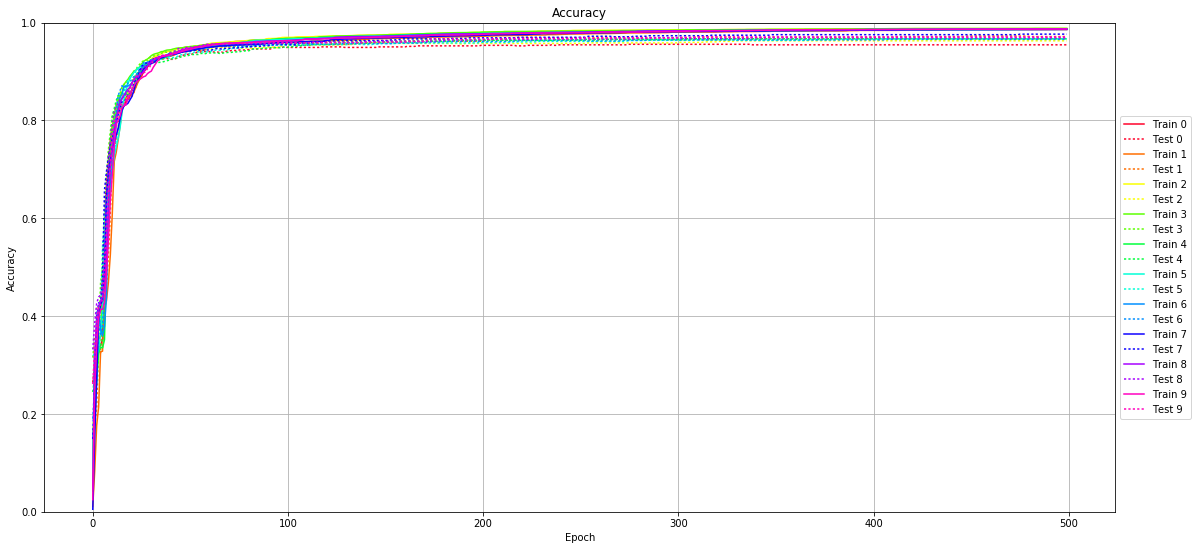

In [15]:
plot_acc(history)

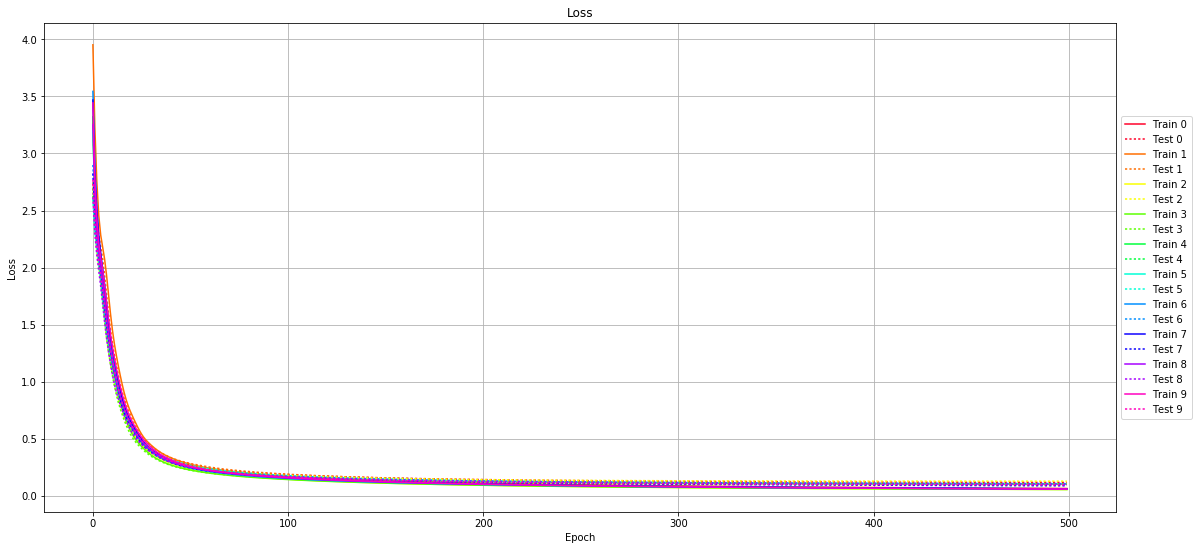

In [16]:
plot_loss(history)

In [17]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


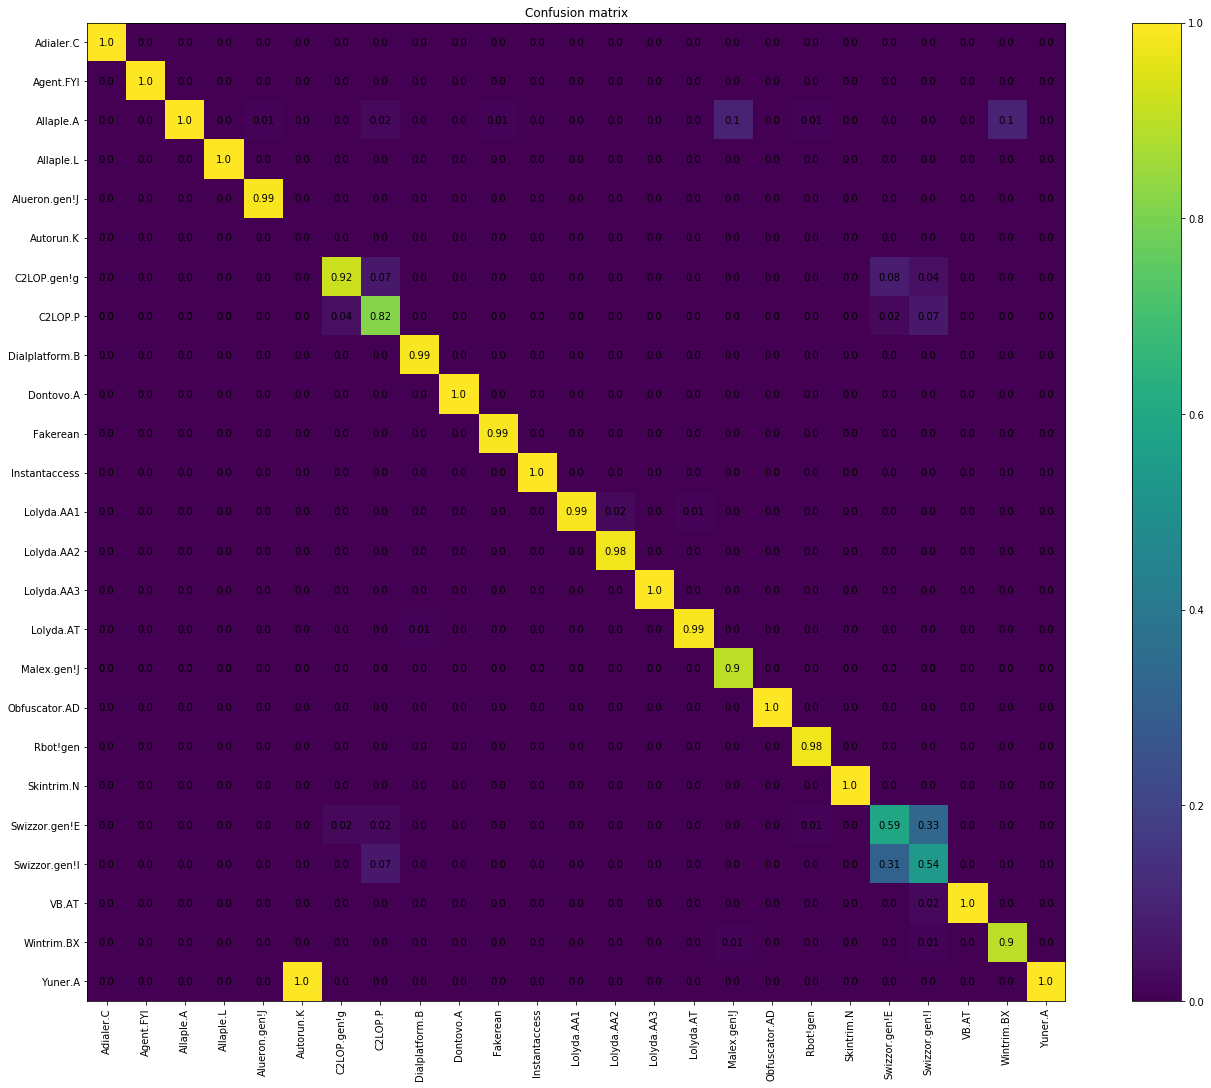

In [18]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()